##Downloading data from kaggle & reading it

In [1]:
import os
# import rapid
# import cupy
import datetime
import re
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import pickle
from time import time
from zipfile import ZipFile
import shutil
import os
import numpy as np
from tqdm import tqdm
from sklearn.manifold import TSNE
import pandas as pd
from multiprocessing import Process
import multiprocessing
import codecs
import random
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from nltk.util import ngrams
from sklearn.feature_selection import SelectKBest, chi2, f_regression
import warnings

import scipy.sparse
import gc
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import math

from sklearn import set_config
set_config(display='diagram')
warnings.filterwarnings( "ignore" )
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
import os
if not os.path.exists('/content/train_data.ftr'):
  
  !pip install kaggle -q
  !mkdir ~/.kaggle 
  !cp kaggle.json ~/.kaggle/

#   !kaggle competitions download -c amex-default-prediction -q
  !kaggle datasets download -d munumbutt/amexfeather -q

In [3]:
# from zipfile import ZipFile
# import os

# if not os.path.exists('/content/train_data.csv'):

#   with ZipFile('/content/amex-default-prediction.zip', 'r') as zipObj:
#       listOfFileNames = zipObj.namelist()

#       # list_ext = ['train_data.ftr','test_data.ftr']
#       # list_ext = ['train_data.ftr']


#       for f_name in listOfFileNames:
#           # if f_name in list_ext:
#             zipObj.extract(f_name)

#     # removing the zip file to freeup the storage
#       !rm /content/amex-default-prediction.zip



# feather file extraction


from zipfile import ZipFile
import os

if not os.path.exists('/content/train_data.ftr'):

  with ZipFile('/content/amexfeather.zip', 'r') as zipObj:
      listOfFileNames = zipObj.namelist()

      list_ext = ['train_data.ftr','test_data.ftr']
    #   list_ext = ['train_data.ftr']

      for f_name in listOfFileNames:
          if f_name in list_ext:
            zipObj.extract(f_name)

    # removing the zip file to freeup the storage
      !rm /content/amexfeather.zip

##Splitting the train & test data into the small chunks as it can't be loaded all at onec.

In [4]:

# def chunking(df_file,path,chunksize):

#   os.makedirs(path)
#   df = pd.read_csv(df_file,chunksize=chunksize)

#   return df



# def compressing_data(df_file,path,chunksize):


#   final_df = pd.DataFrame()
#   df = chunking(df_file,path,chunksize)

#   for i,x in enumerate(df):

#     if i == 0:
#       cat_col = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_66', 'D_68']
#       num_col = [x for x in x.columns if x not in cat_col+['customer_ID','S_2']]
#       str_col = [ 'D_63', 'D_64',]
    
#     x['S_2'] = pd.to_datetime(x['S_2'])
#     x[num_col] = x[num_col].astype('float16')
#     x[cat_col] = x[cat_col].astype('float16')
#     x[str_col] = x[str_col].astype('category')

#     final_df = pd.concat([final_df,x])

#   file_name = df_file.split('.')[0]
#   final_df.reset_index(drop=True).to_feather(path + f'{file_name}.ftr')

#   del final_df, df, x,file_name


# if not os.path.exists('train_data.ftr'):

#   compressing_data('train_data.csv','/content/train_chunk/',100000)


# # if not os.path.exists('test_data.ftr'):

# #   compressing_data('test_data.csv','/content/test_chunk/',100000)






## Exploratory Data Analysis

In [5]:
train = pd.read_feather('train_data.ftr')
train_label = pd.read_csv('train_labels.csv')

In [6]:
train.head()

customer_ID        S_2       P_2  \
0  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f... 2017-03-09  0.938477   
1  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f... 2017-04-07  0.936523   
2  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f... 2017-05-28  0.954102   
3  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f... 2017-06-13  0.960449   
4  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f... 2017-07-16  0.947266   

       D_39       B_1       B_2       R_1       S_3      D_41       B_3  ...  \
0  0.001734  0.008728  1.006836  0.009224  0.124023  0.008774  0.004707  ...   
1  0.005775  0.004925  1.000977  0.006153  0.126709  0.000798  0.002714  ...   
2  0.091492  0.021652  1.009766  0.006817  0.123962  0.007599  0.009422  ...   
3  0.002455  0.013687  1.002930  0.001372  0.117188  0.000685  0.005531  ...   
4  0.002483  0.015190  1.000977  0.007607  0.117310  0.004654  0.009308  ...   

   D_137  D_138     D_139     D_140     D_141  D_142     D_143     D_144  \
0    NaN    NaN  0.002426  0.003706  0.003819    NaN  0.000569  0.000610   
1    NaN    NaN  0.003956  0.003166  0.005032    NaN  0.009575  0.005493   
2    NaN    NaN  0.003269  0.007328  0.000427    NaN  0.003429  0.006985   
3    NaN    NaN  0.006119  0.004517  0.003201    NaN  0.008423  0.006527   
4    NaN    NaN  0.003672  0.004944  0.008888    NaN  0.001670  0.008125   

      D_145  target  
0  0.002674       0  
1  0.009216       0  
2  0.002604       0  
3  0.009598       0  
4  0.009827       0  

[5 rows x 191 columns]

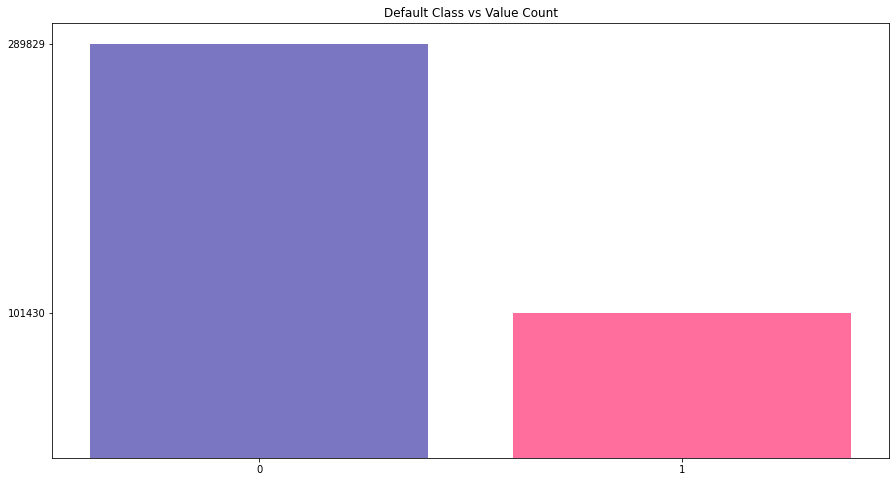

In [9]:
target = train_label['target'].value_counts()

plt.figure(figsize=[15,8])
plt.bar(target.keys(),target.values,color=['#7A76C2','#ff6e9c'])
plt.xticks(target.keys())
plt.yticks(target.values)
plt.title('Default Class vs Value Count')
plt.show()




*  Train Data is Imbalanced.



In [10]:
train.columns

Index(['customer_ID', 'S_2', 'P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41',
       'B_3',
       ...
       'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143', 'D_144',
       'D_145', 'target'],
      dtype='object', length=191)

In [11]:
column_type = [x for x in zip(train.dtypes.keys(),train.dtypes.values)]

print(f"total No of 'float16' columns in train data:{len([x for x in column_type if x[1]=='float16'])}\n")
print(f"total No of 'Categorical' columns in train data:{len([x for x in column_type if (x[1]!='float16' and x[1]!='int64') and x[0] not in ['cutomer_ID','S_2']])} \n {[x[0] for x in column_type if (x[1]!='float16' and x[1]!='int64') and x[0] not in ['customer_ID','S_2']]}\n")
print(f"total No of 'int64' columns in train data:{len([x for x in column_type if x[1]=='int64'])}\n {[x[0] for x in column_type if x[1]=='int64']}")


total No of 'float16' columns in train data:177

total No of 'Categorical' columns in train data:12 
 ['D_63', 'D_64', 'D_66', 'D_68', 'B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126']

total No of 'int64' columns in train data:1
 ['target']


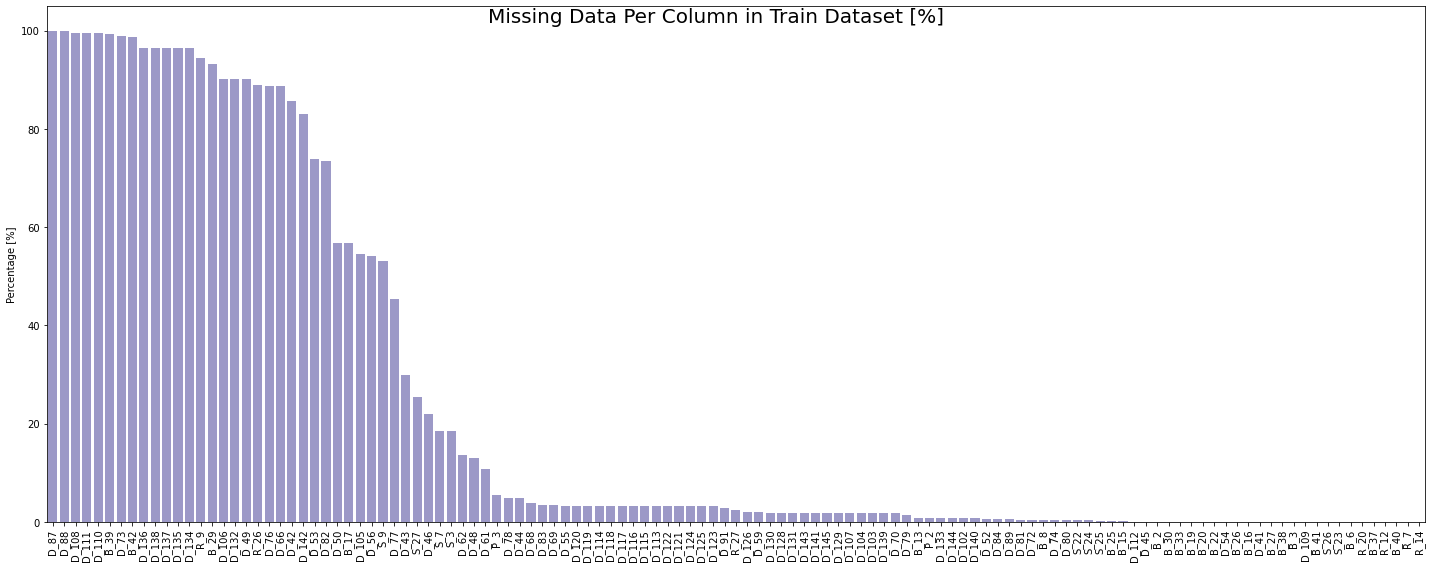

In [12]:
null_values = ((train.isnull().sum()/len(train))*100).sort_values(ascending=False)
null_values = null_values[null_values!=0]


fig, ax = plt.subplots(1,1, figsize=(20,8))
sns.barplot(x=null_values.index, y=null_values.values, ax=ax, color='#7A76C2', alpha = 0.8)
ax.set_ylabel('Percentage [%]')
ax.tick_params(axis='x', rotation=90)
plt.suptitle("Missing Data Per Column in Train Dataset [%]", fontsize = 20)
plt.tight_layout()
plt.show()



*   121 variables has null values.
*   The following 25 variables has more than 60% missing values:
  * D_87, D_88, D_108, D_111, D_110, B_39, D_73, B_42,
       D_136, D_138, D_137, D_135, D_134, R_9, B_29, D_106,
       D_132, D_49, R_26, D_76, D_66, D_42, D_142, D_53,
       D_82.
* There are total of 96 D_ variable columns & 20 variables has more than 60% missing values.
* we would need to deal with the missing values.
  * we can use the Imputaion method or we can use XGBoost as it can handle missing values very easily.



## Univarate Analysis

In [13]:
print(f"Train data ranges from: {train['S_2'].min()} to {train['S_2'].max()}")
print(f"Total no of days data in the training dataset: {train['S_2'].max() - train['S_2'].min()}")


Train data ranges from: 2017-03-01 00:00:00 to 2018-03-31 00:00:00
Total no of days data in the training dataset: 395 days 00:00:00


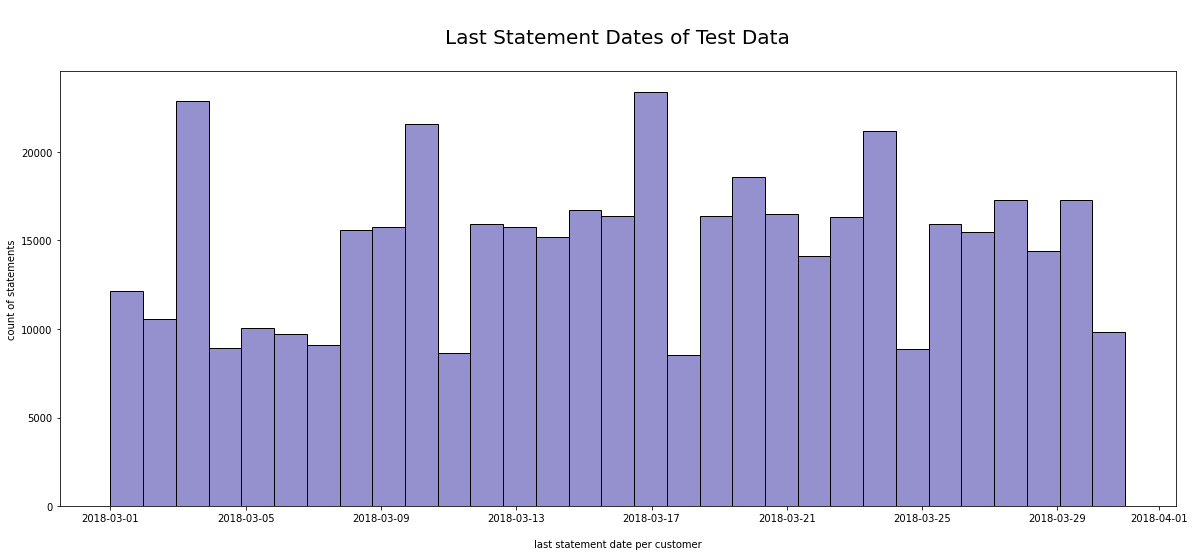

In [14]:
fig, ax = plt.subplots(1,1, figsize=(20,8))
temp  = train.S_2.groupby(train.customer_ID).max().reset_index().sort_values('S_2').set_index('customer_ID')

sns.histplot(x='S_2', data=temp, bins=len(pd.date_range(temp.min()[0], temp.max()[0], freq="d")), ax=ax,  color='#7A76C2', alpha = 0.8)
ax.set_title('\nLast Statement Dates of Test Data\n', fontsize=20)
ax.set_xlabel('\nlast statement date per customer')
ax.set_ylabel('count of statements')
plt.show()

del temp
_ = gc.collect()

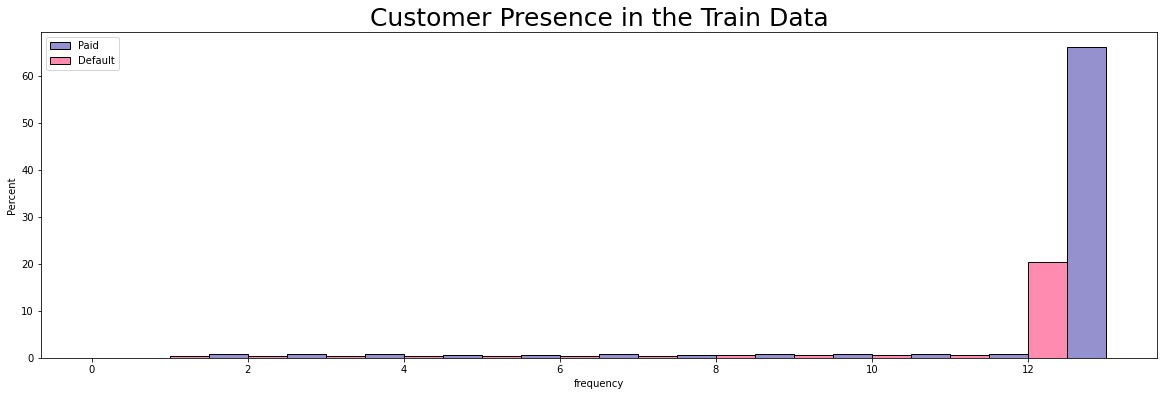

In [15]:
#number of unique customers and their presence in train data
fig, ax = plt.subplots(1,1, figsize=(20,6))
temp = train.groupby(['customer_ID', 'target']).size().reset_index().rename(columns={0:'frequency'})
sns.histplot(x='frequency',hue='target',hue_order=[1,0], stat='percent', bins=np.arange(0,14), data=temp, ax=ax,
             multiple='dodge',alpha = 0.8,palette=['#ff6e9c','#7A76C2'])

ax.set_title('Customer Presence in the Train Data', fontsize = 25)
ax.legend(loc=0, labels=['Paid','Default'])
plt.show()

## Box Plot

KDE plots

In [16]:
import math
# from sci_utilities import is_outlier

sns.set_style('darkgrid')

def kde_plotter(feature_type, fig_size):
    categorical_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

    cols = [x for x in train.columns if (x not in categorical_features) & (x.split('_')[0]==feature_type) & (x not in ['S_2'])]
    c = 4
    r = math.ceil((len(cols)-1)/c)
    fig, axes = plt.subplots(r,c,figsize=fig_size)

    
    for i, ax in enumerate(axes.reshape(-1)):
        if i<=len(cols)-1:
            sns.kdeplot(x=cols[i], hue ='target', data=train, fill=True,hue_order=[1,0], linewidth=2, 
                            palette=['#7A76C2','#ff6e9c'],ax=ax)
            ax.tick_params(left=False, bottom=False, labelsize=5)
            ax.xaxis.get_label().set_fontsize(10)
            ax.set_ylabel('')  
        if i==0:
            ax.legend(loc=2, bbox_to_anchor=(-0.35,1), labels=['Paid','Default'])
        # else:
            # ax.get_legend().remove()

    sns.despine(bottom=True, trim=True)
    plt.tight_layout(rect=[0, 0.2, 1, 0.98])        
    plt.suptitle(f'\nDistributions of {feature_type}_* Variables\n', fontsize=20,y=1.05)
    plt.show()

##P_* Variable

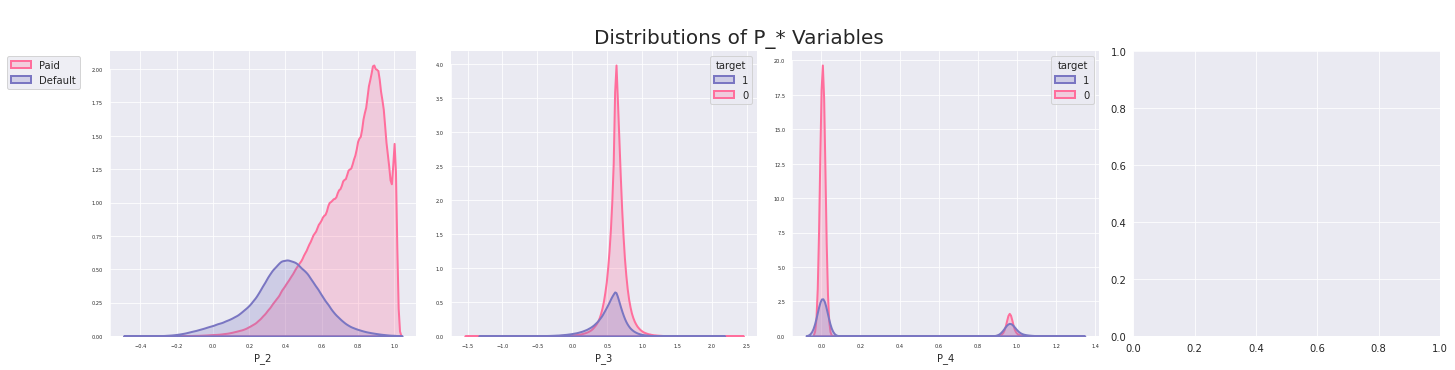

In [ ]:
kde_plotter('P',(20,6))



*   There are 3 type of P variables:
  * P_2, P_3, P_4.
* P_3 & P_4 has compltely overlapping denisty plot & hence it will be difficult to distinguish between defualter & non-defaulter using these 2 features.

* in feature P_2 the density curve is not completely overlaping & the class ( 0: non-defualter) has left screwd density curve.



##R_* Variable

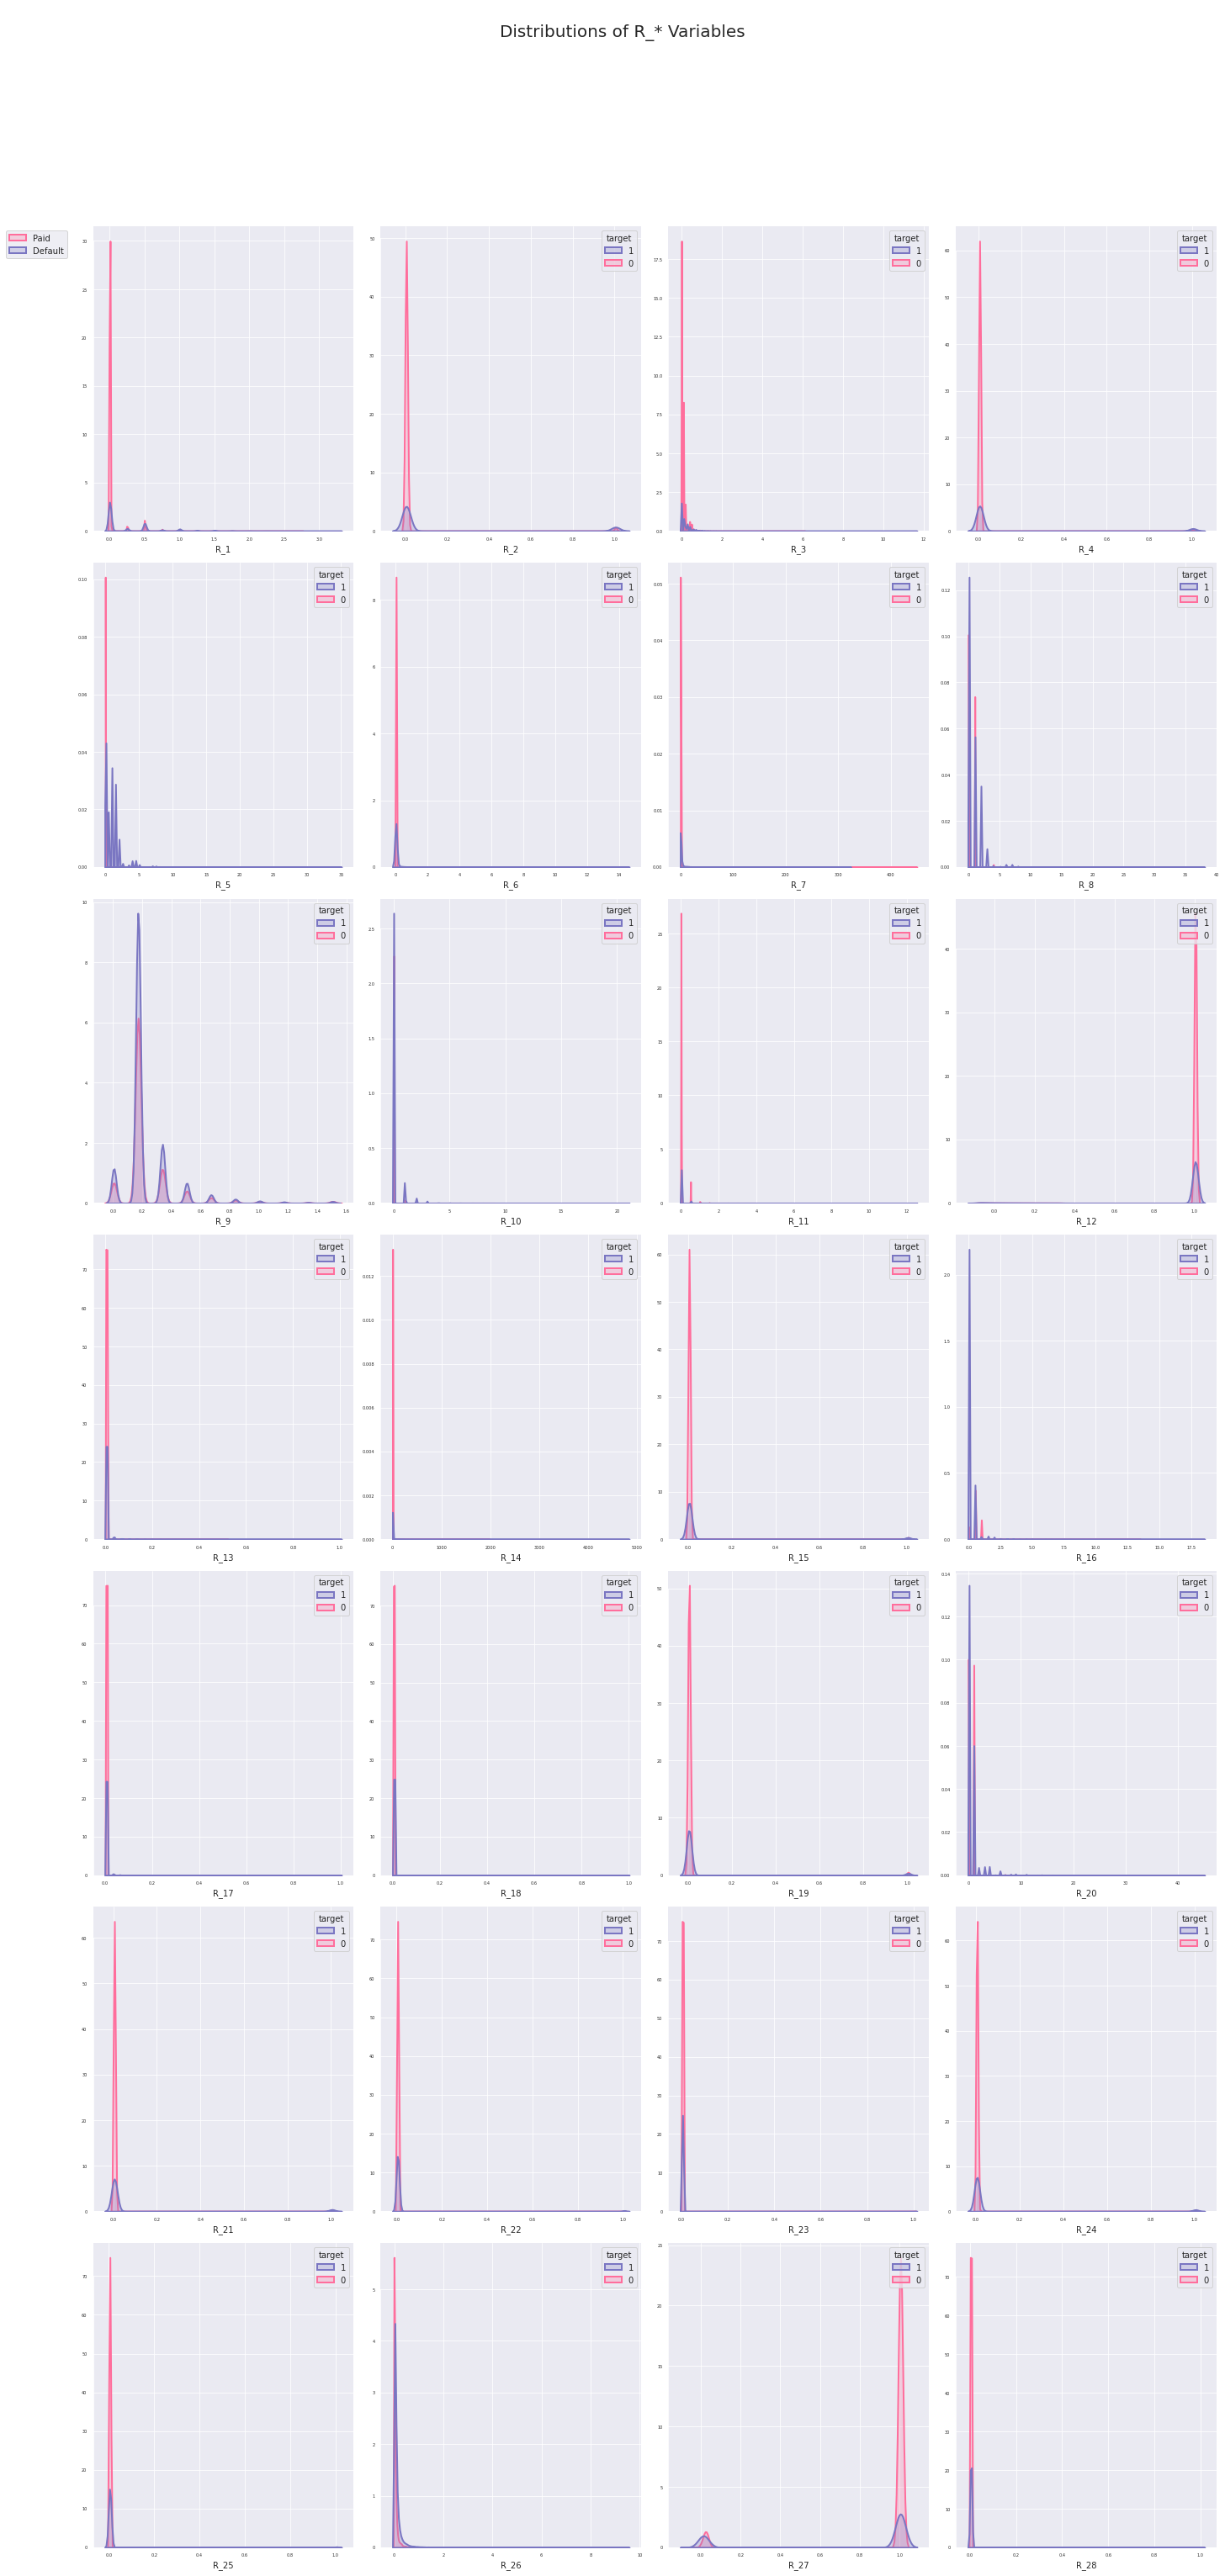

In [ ]:
kde_plotter('R',(20,50))

##B_* Variables

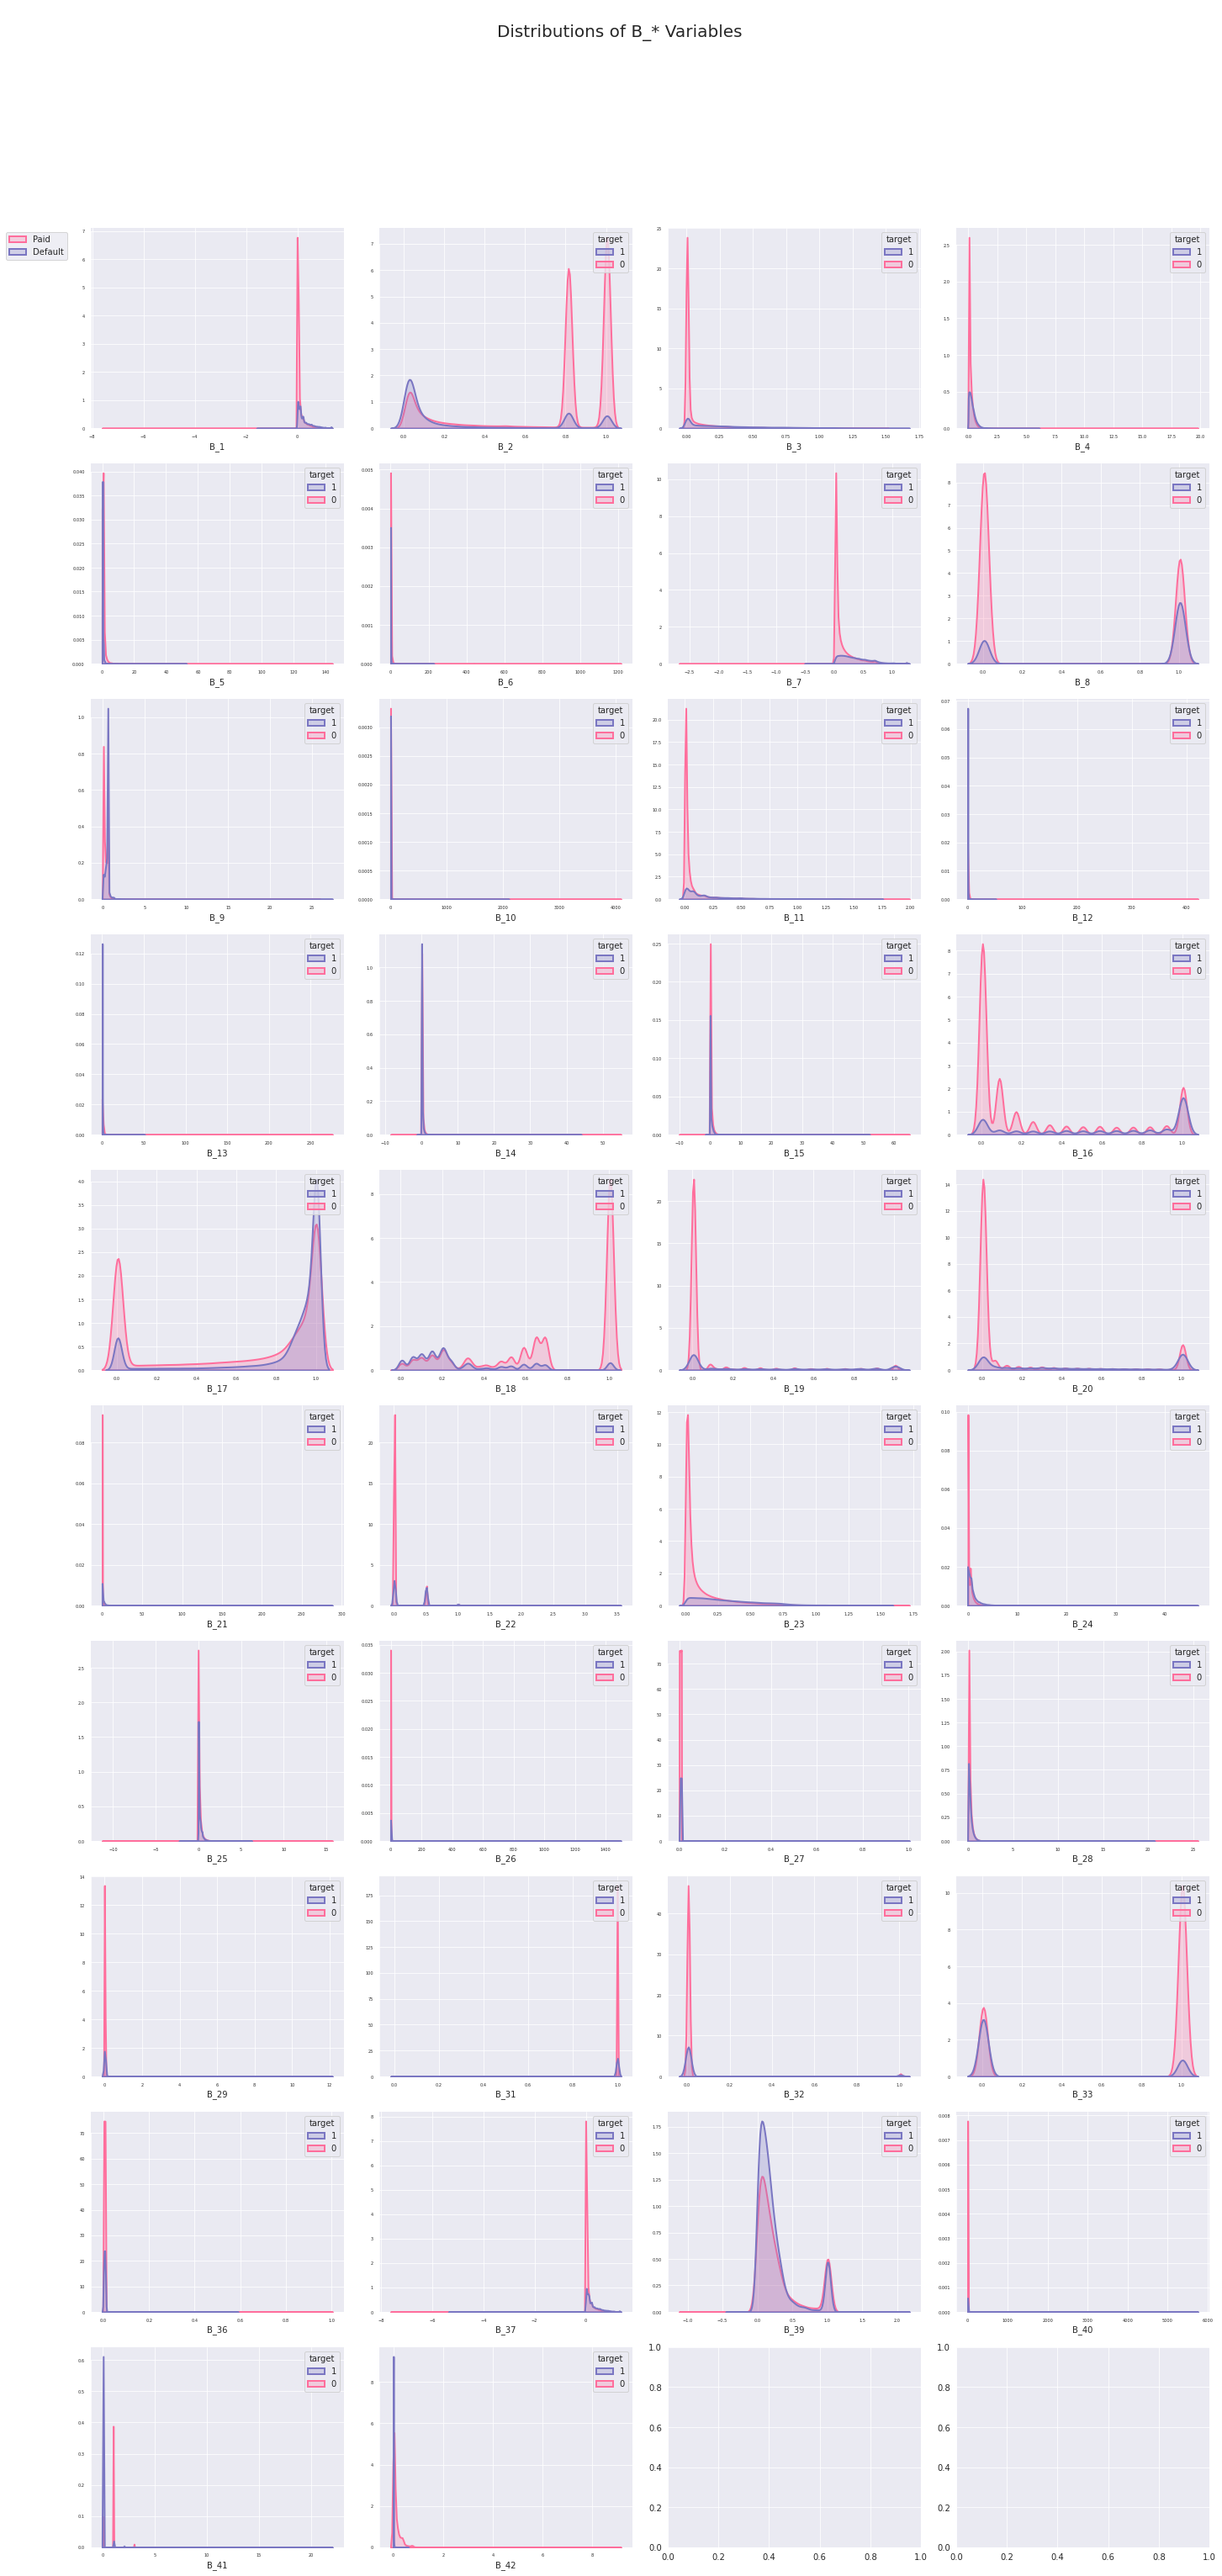

In [ ]:
kde_plotter('B',(20,50))

##D_* Variables

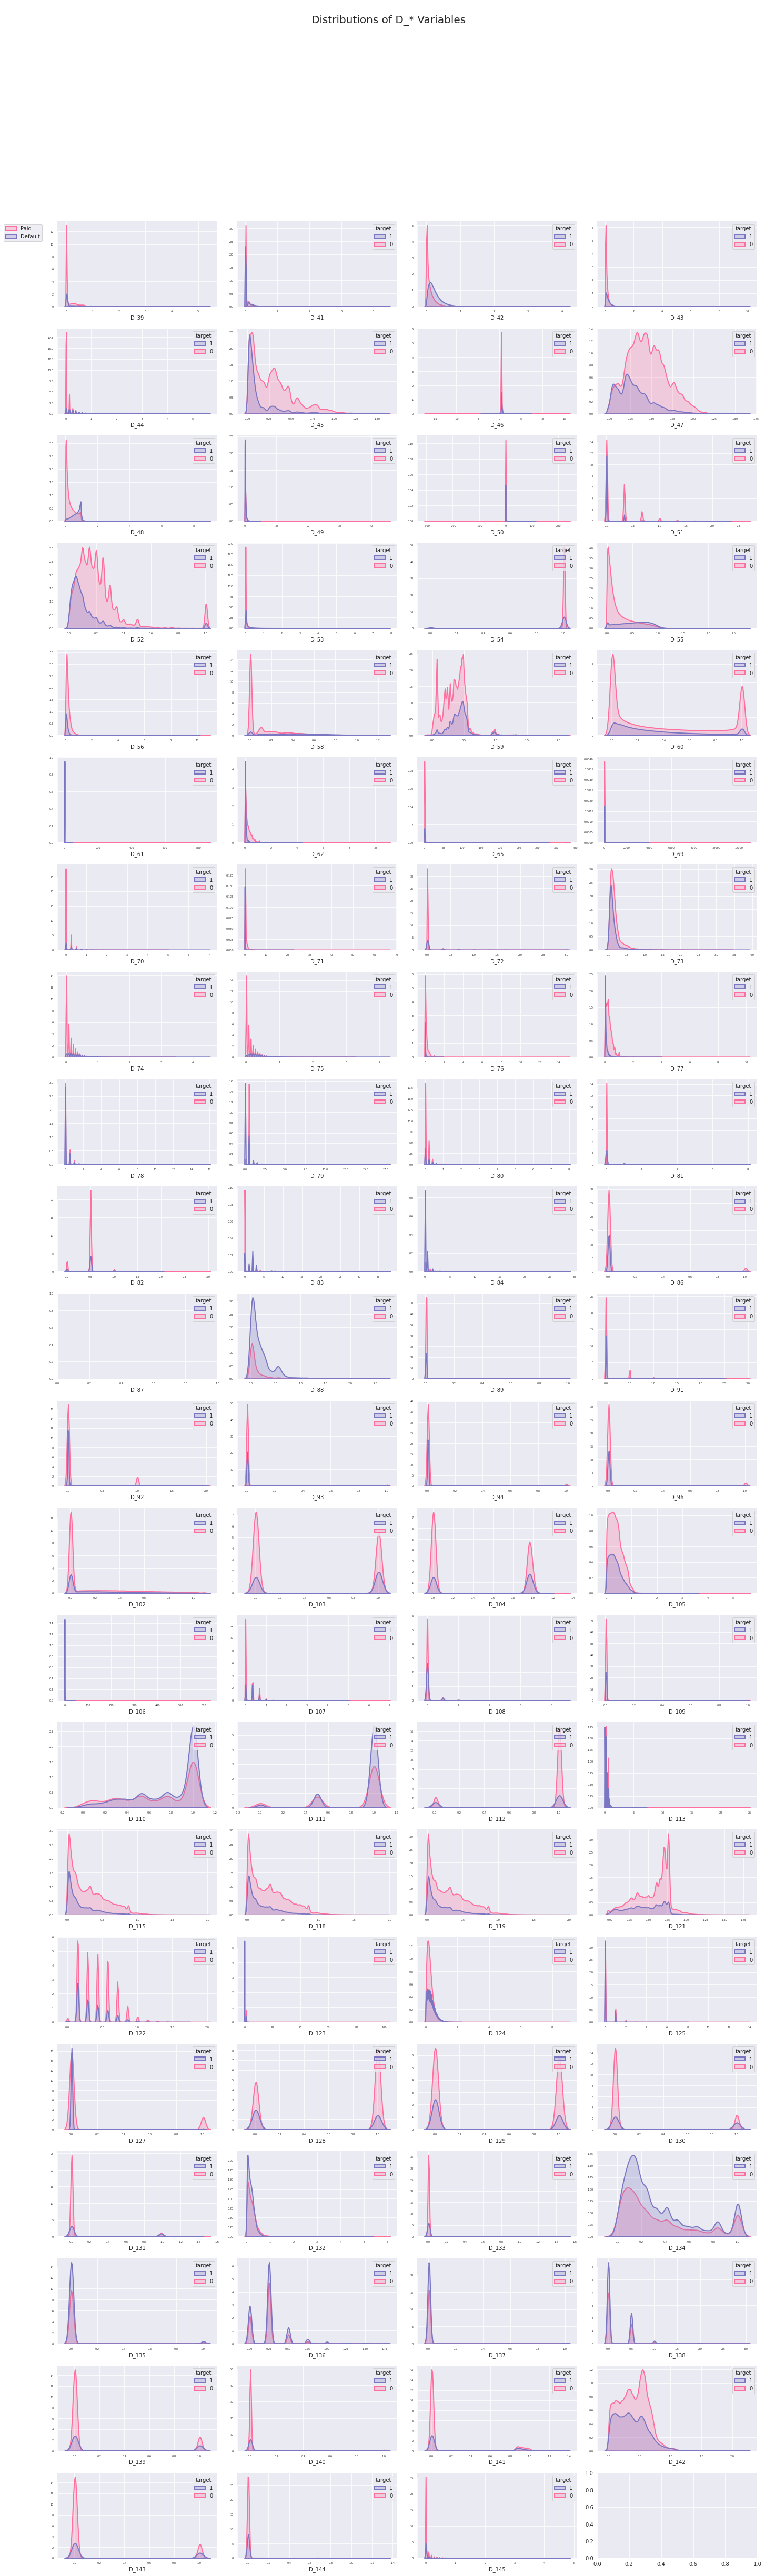

In [ ]:
kde_plotter('D', (20,80))

##S_* Variables

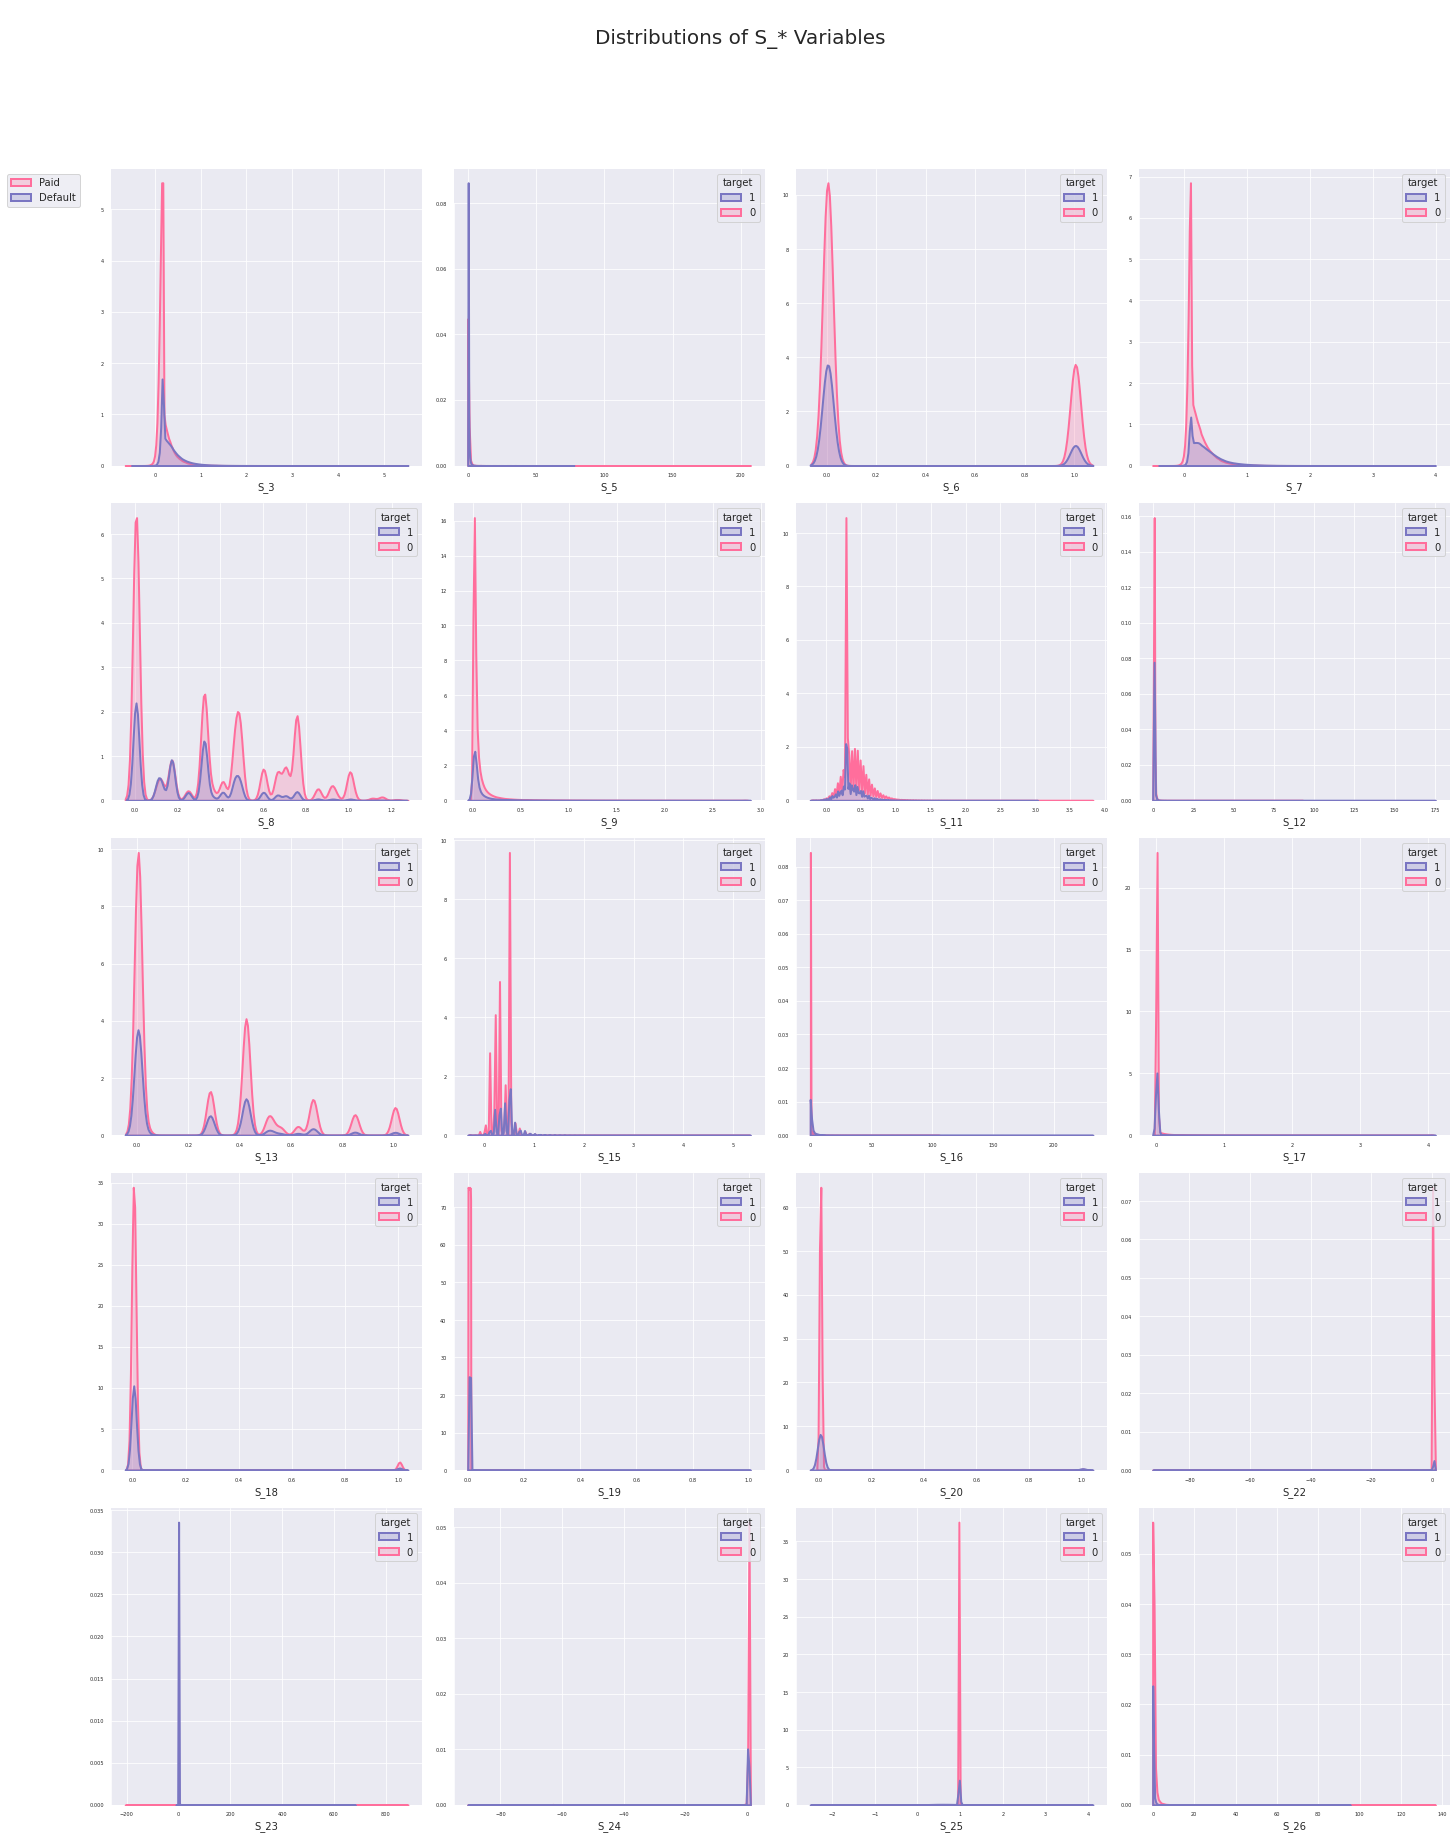

In [ ]:
kde_plotter('S', (20,30))

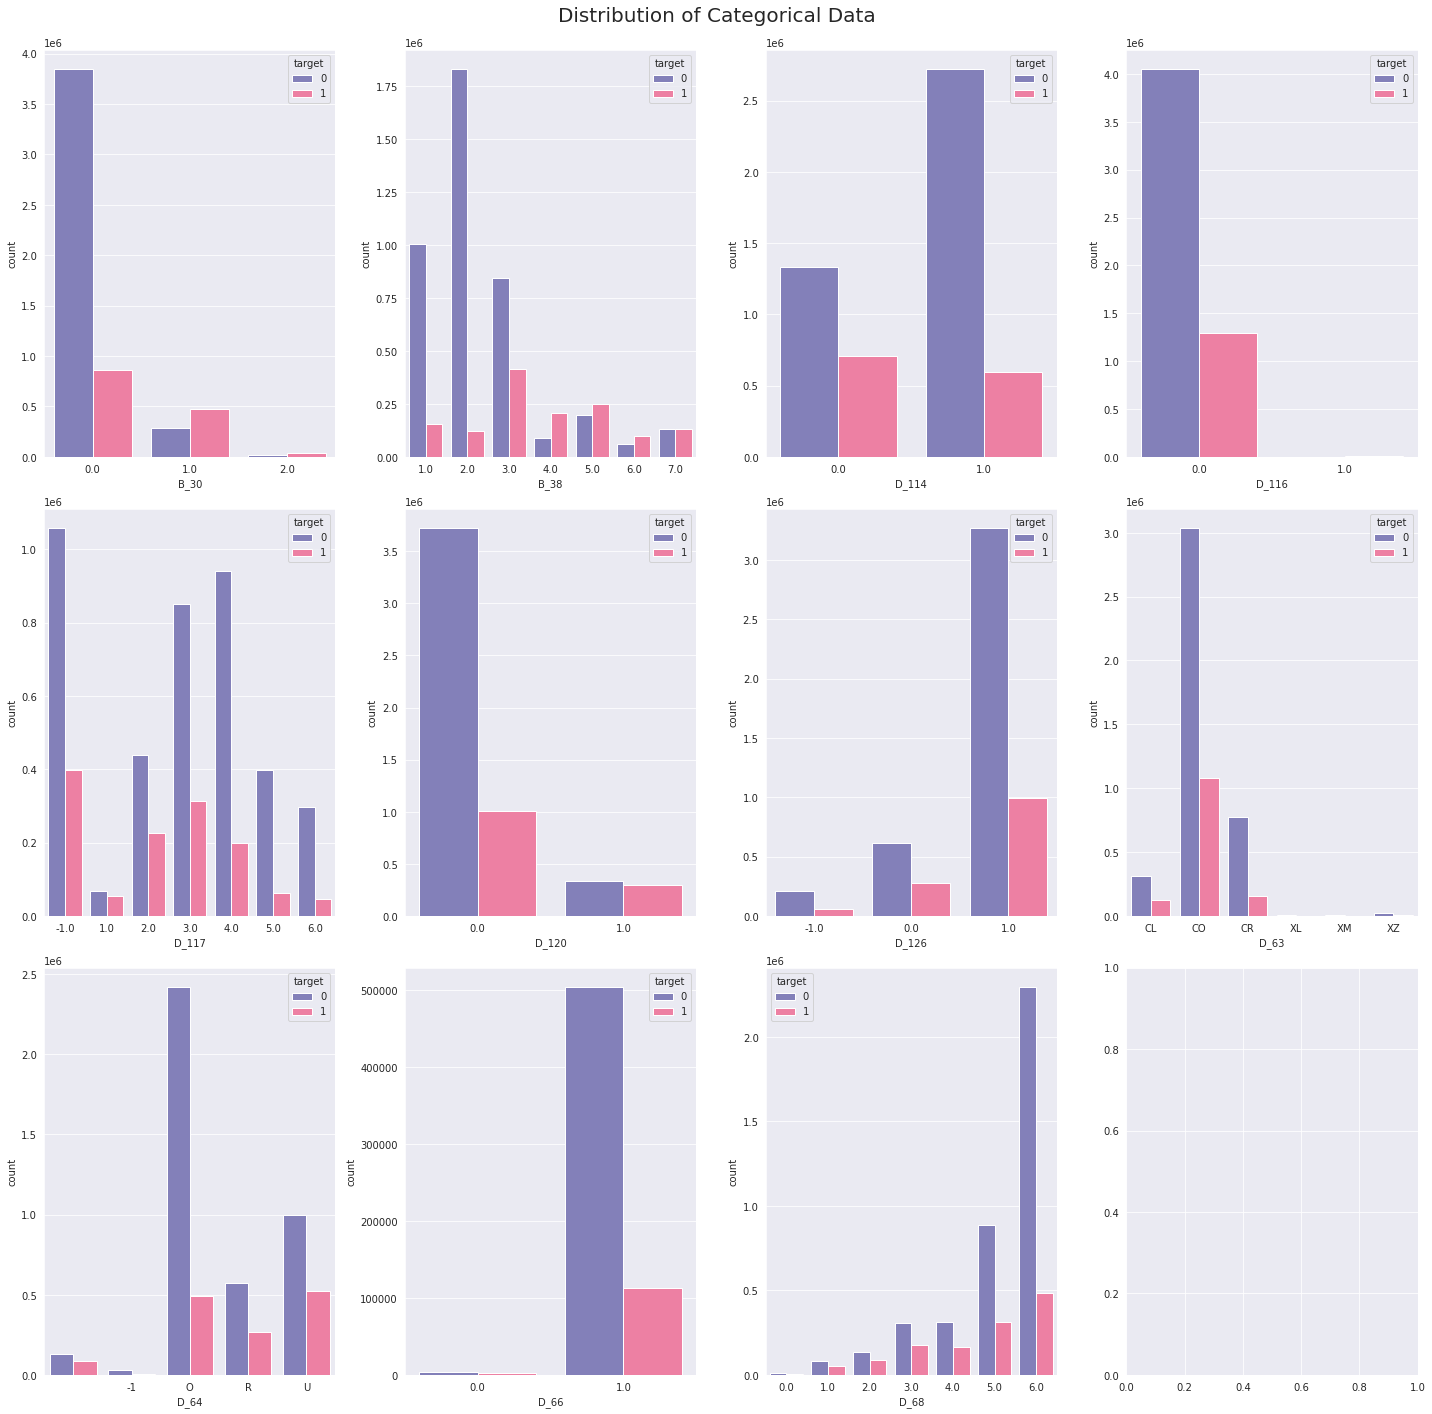

In [19]:
# distrubution of categorical values

categorical_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

cols = categorical_features + ['target']
temp=train[cols]
fig, axes = plt.subplots(3, 4, figsize=(20,20))
for i, ax in enumerate(axes.reshape(-1)):
    if i<len(cols)-1:
        sns.countplot(x=cols[i], hue='target', data=temp, ax=ax,palette=['#7A76C2','#ff6e9c'])
plt.suptitle("Distribution of Categorical Data", fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

del temp
_ = gc.collect()

* Categorical Columns:
  * The distributions for target (0,1) differ by a quite a margin, this is helpful for modeling
  * B_30:
    * 0: 85% data has value 0.
    * 1: 13% data has value 1.
    * 2: 1% data has value 2.
    * nan: 1% data has value nan.
  * D_116:
    * 0: 96.6% data has value 0.
    * 1: 0.1% data has value 1
    * nan: 3.3% data has value nan.

# Box Plots

In [ ]:
import math

sns.set_style('darkgrid')

def box_plotter(feature_type, fig_size):
    categorical_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

    cols = [x for x in train.columns if (x not in categorical_features) & (x.split('_')[0]==feature_type) & (x not in ['S_2'])]
    c = 4
    r = math.ceil((len(cols)-1)/c)
    fig, axes = plt.subplots(r,c,figsize=fig_size)

    
    for i, ax in enumerate(axes.reshape(-1)):
        if i<=len(cols)-1:
            sns.boxplot(x=cols[i], hue ='target', data=train,hue_order=[1,0], 
                            palette=['#7A76C2','#ff6e9c'],ax=ax)
            ax.tick_params(left=False, bottom=False, labelsize=5)
            ax.xaxis.get_label().set_fontsize(10)
            ax.set_ylabel('')  
        if i==0:
            ax.legend(loc=2, bbox_to_anchor=(-0.35,1), labels=['Paid','Default'])

    sns.despine(bottom=True, trim=True)
    plt.tight_layout(rect=[0, 0.2, 1, 0.98])        
    plt.suptitle(f'\nDistributions of {feature_type}_* Variables\n', fontsize=20,va='top',y=1.005)
    plt.show()

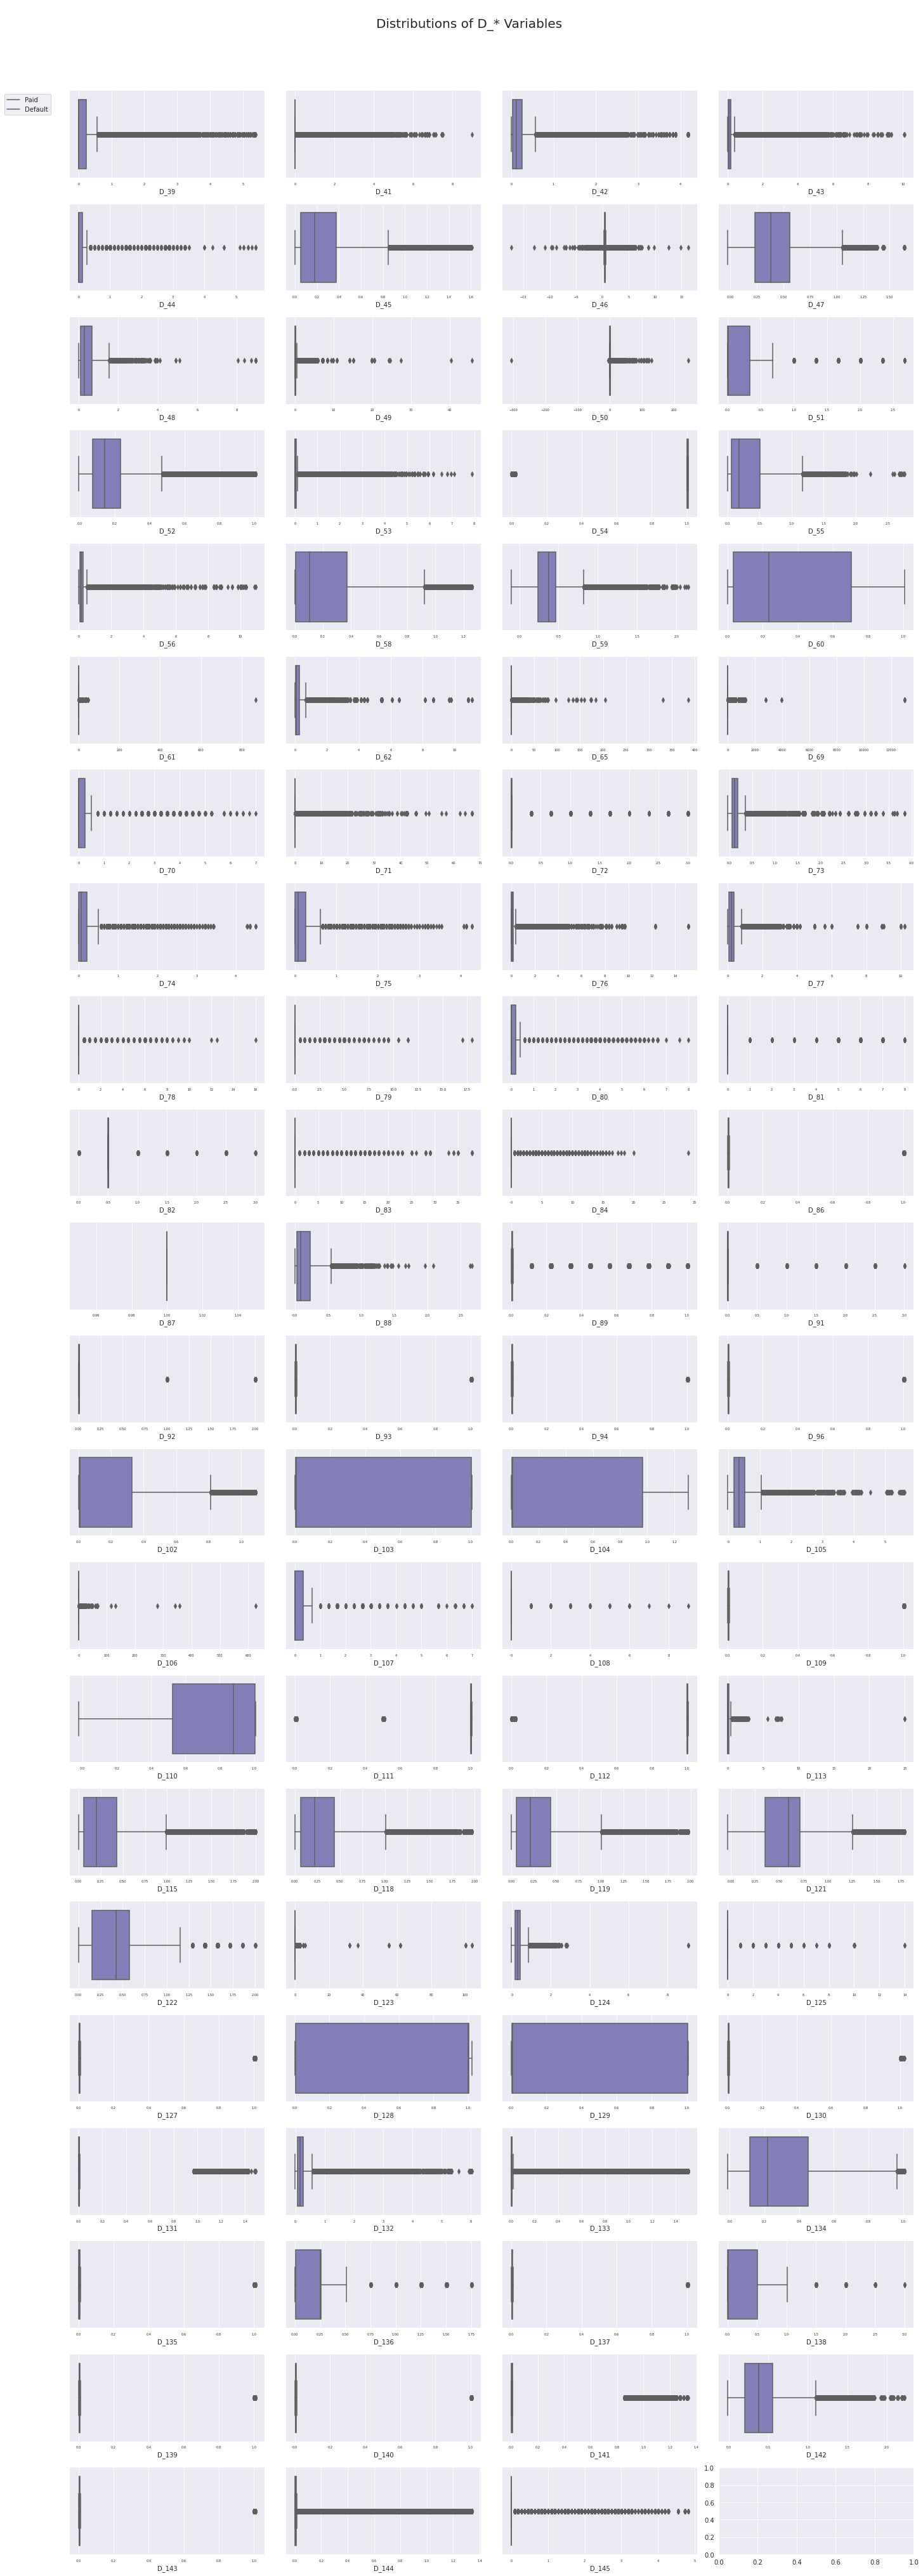

In [ ]:
box_plotter('D',(20,70))

* Variable D:
    * Except feature D_60, D_103, D_104, D_110, D_128, D_129  all the B feature variable has outliers.
    * from the Box plot we can inferr that 99% of data point lies between 0 to 1.
    * where as the outliers changes the scale & hence we would need to handle the outliers as it can affect the Models Performance.


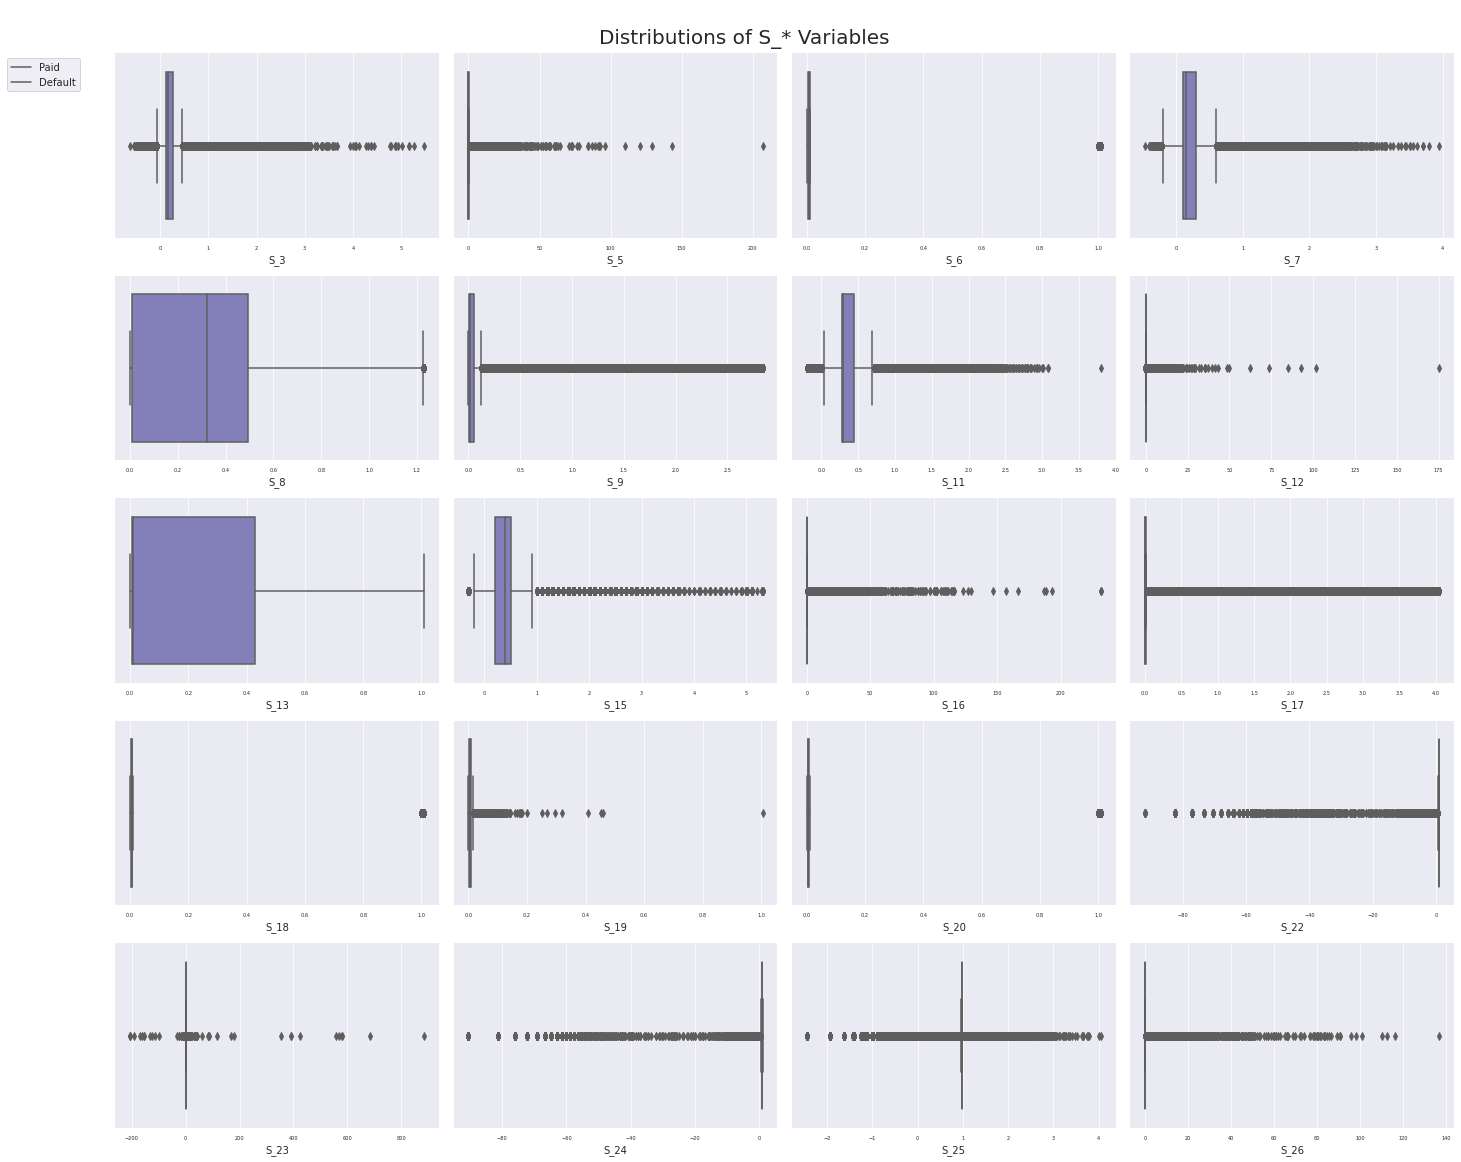

In [ ]:
box_plotter('S',(20,20))

* Variable S:
    * Except feature S_13 all the S feature variable has outliers.
    * from the Box plot we can inferr that 99% of data point lies between 0 to 1.
    * where as the outliers changes the scale & hence we would need to handle the outliers.


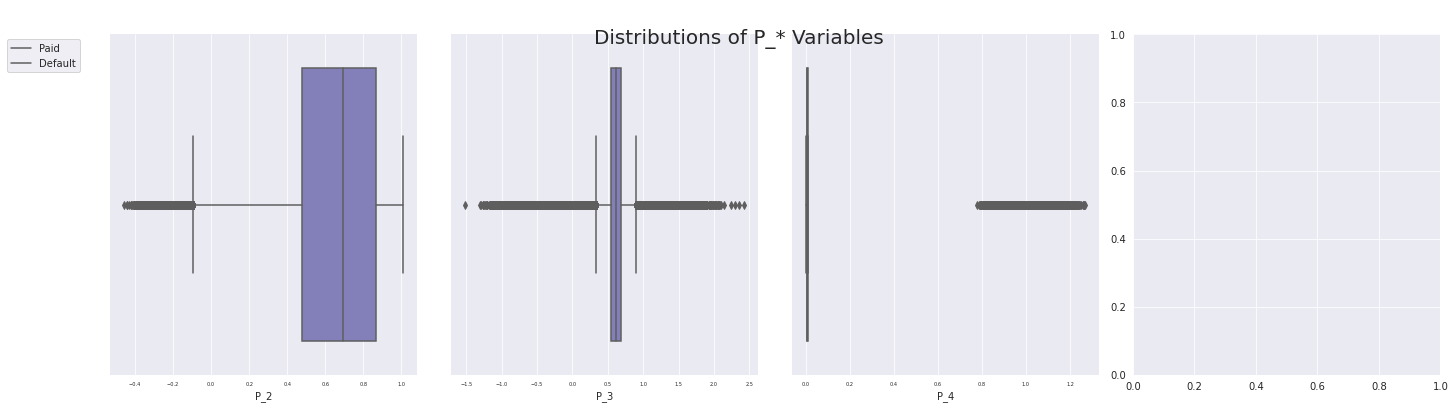

In [ ]:
box_plotter('P',(20,7))

* Variable P:
    * all the P feature variable has outliers.
    * from the Box plot we can inferr that 99% of data point lies between 0 to 1.
    * where as the outliers changes the scale & hence we would need to handle the outliers.


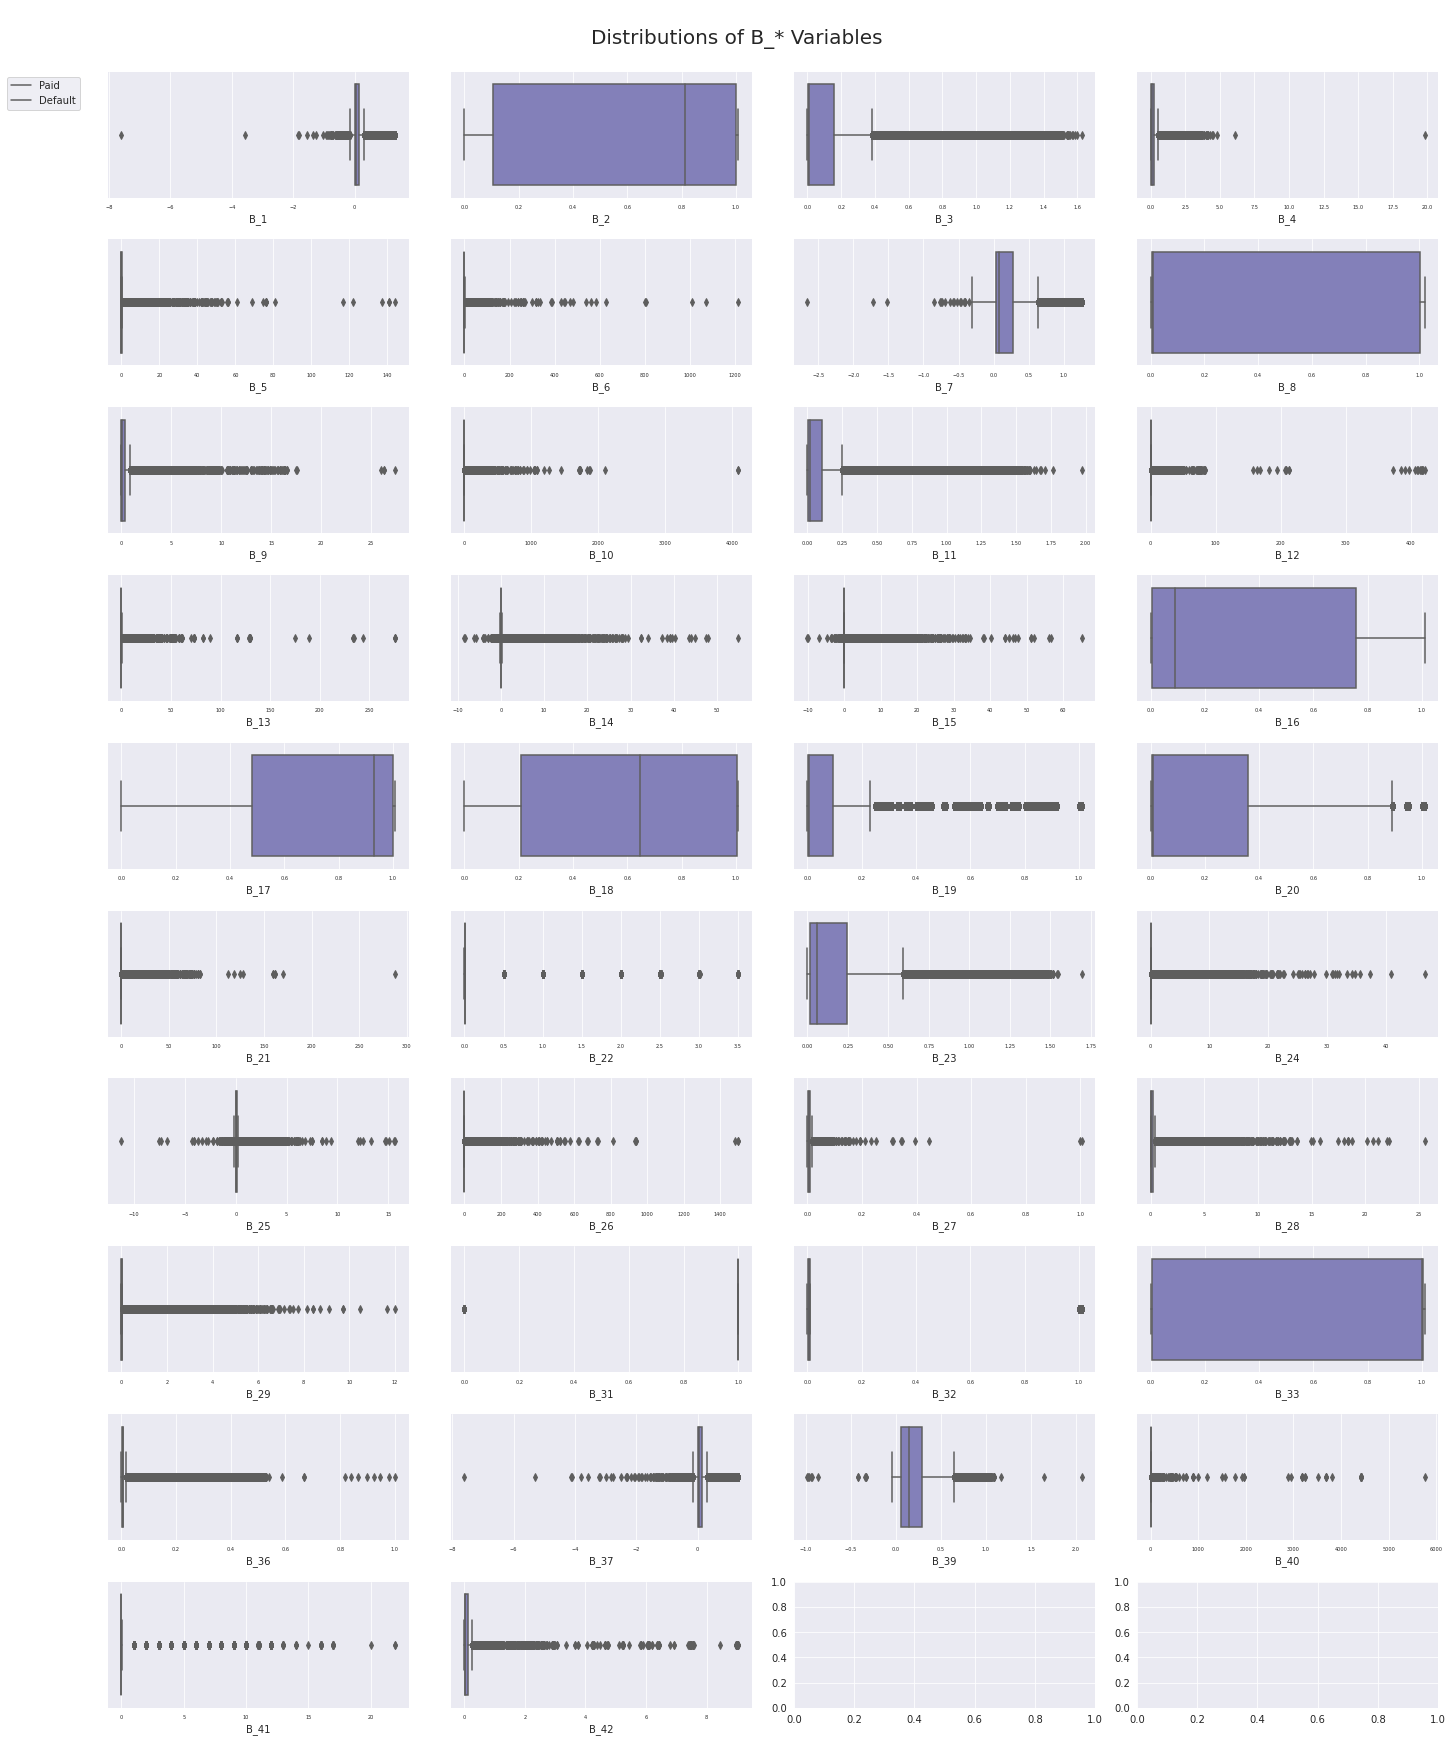

In [ ]:
box_plotter('B',(20,30))

* Variable B:
    * Except feature B_2, B_8, B_16, B_17, B_18, B_20, B_33  all the B feature variable has outliers.
    * from the Box plot we can inferr that 99% of data point lies between 0 to 1.
    * where as the outliers changes the scale & hence we would need to handle the outliers.


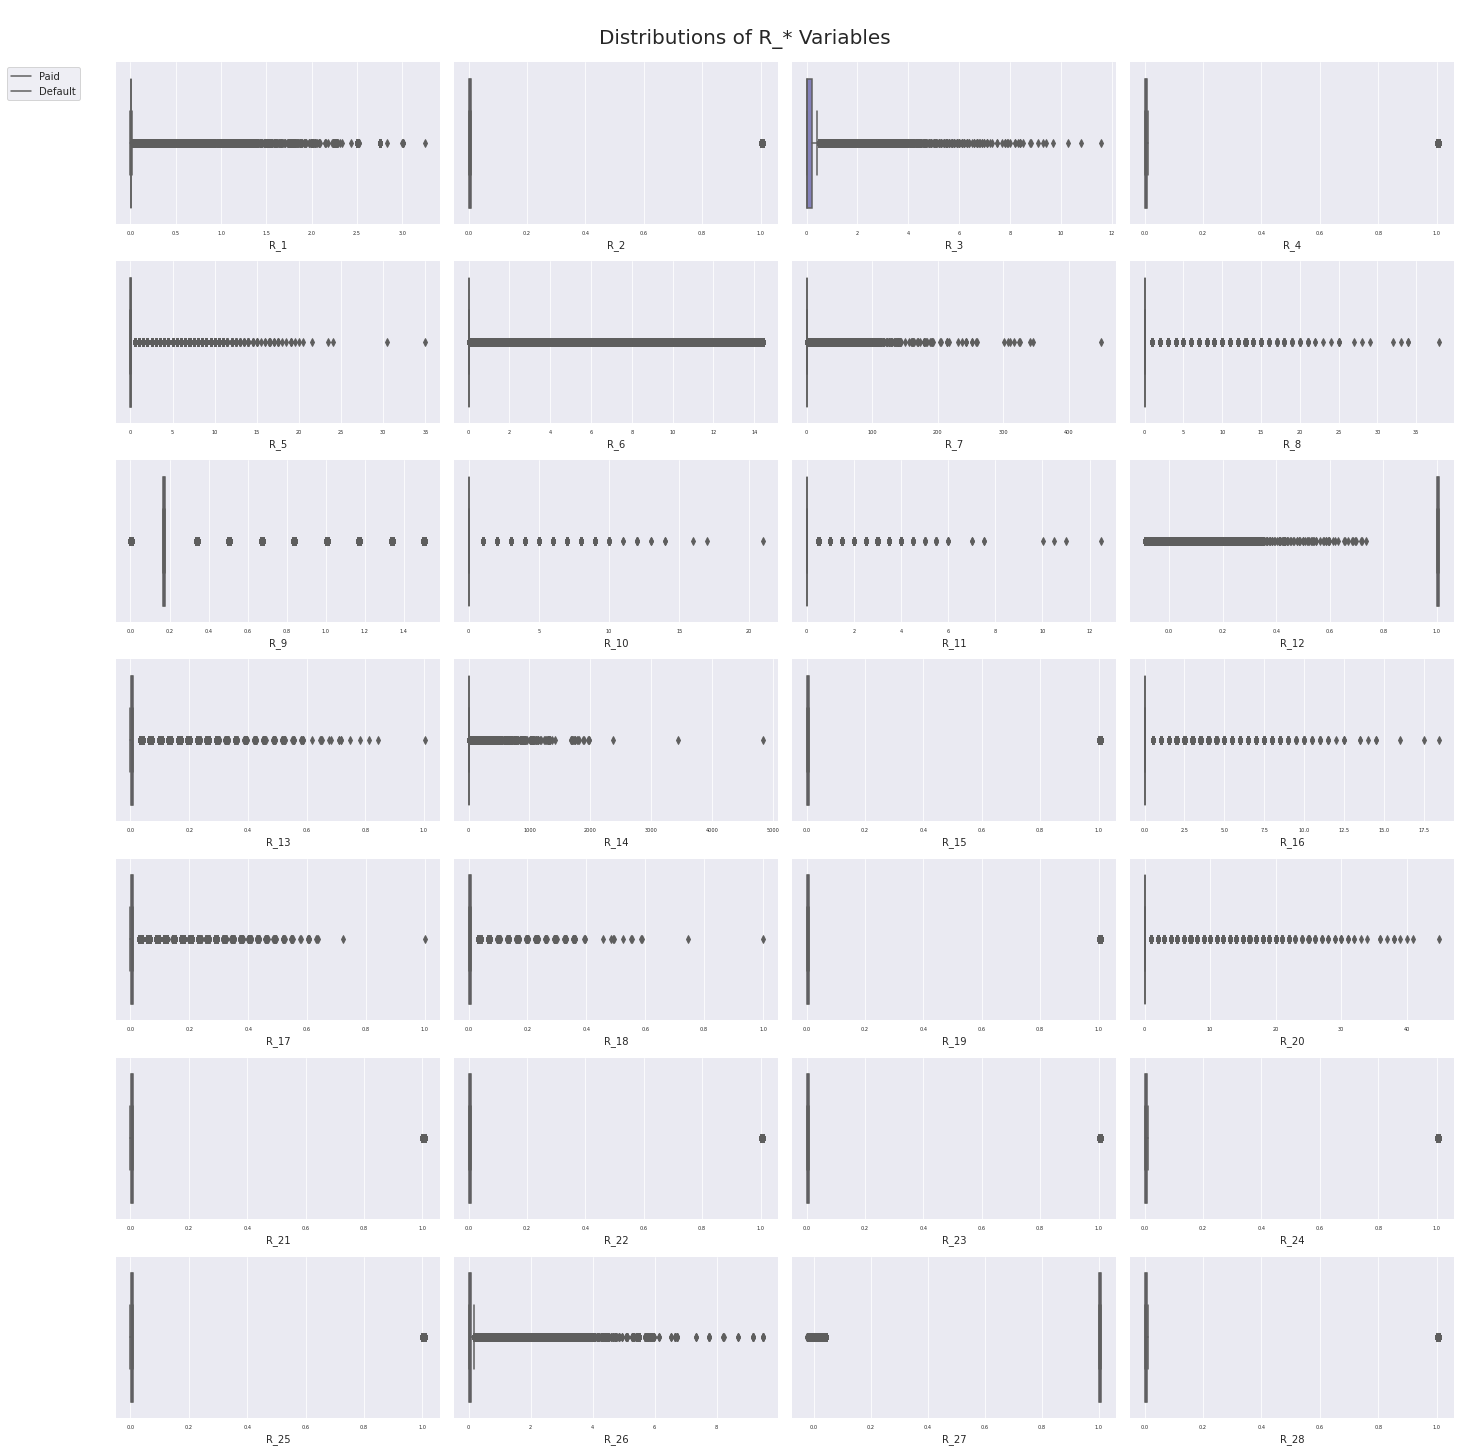

In [ ]:
box_plotter('R',(20,25))
_ = gc.collect()

* Variable R:
    * all the R feature variable has outliers.
    * from the Box plot we can inferr that 99% of data point lies between 0-1.
    * where as the outliers changes the scale & hence we would need to handle the outliers.


# Correlation

In [ ]:
# fig,ax = plt.subplots(figsize=(178,178))
# sns.heatmap(temp,mask=mask,vmin=-1,vmax=1,center=0,annot=True,fmt='.2f',cmap='RdBu_r', cbar=True)


def heatmap_plotter(feature='all',figure=(178,178)):

    if feature == 'all':
        temp = train.corr()
        mask = np.triu(np.ones_like(temp))

        fig, ax = plt.subplots(figsize=figure)
        sns.heatmap(temp,mask=mask,vmin=-1,vmax=1,center=0,annot=True,fmt='.2f',cmap='RdBu_r', cbar=True)
        ax.tick_params(left=False, bottom=False)
        ax.set_xticklabels(ax.get_xticklabels(),horizontalalignment='right', fontsize=12, rotation=45)
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
        plt.suptitle(f"Correlation Between All Numerical Variables", fontsize=50)
        plt.show()

        del temp
        _ = gc.collect()

    else:
        col = [x for x in train.columns if x not in ['S_2','customer_ID'] and x.split('_')[0]==feature]
        temp = train[col+['target']].corr()
        mask = np.triu(np.ones_like(temp))

        fig, ax = plt.subplots(figsize=figure)
        sns.heatmap(temp,mask=mask,vmin=-1,vmax=1,center=0,annot=True,fmt='.2f',cmap='RdBu_r', cbar=True)
        ax.tick_params(left=False, bottom=False)
        ax.set_xticklabels(ax.get_xticklabels(),horizontalalignment='right', fontsize=12, rotation=45)
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
        plt.suptitle(f"Correlation Between {feature}_* Variables", fontsize=figure[0]*0.9)
        plt.show()

        del temp
        _ = gc.collect()
        


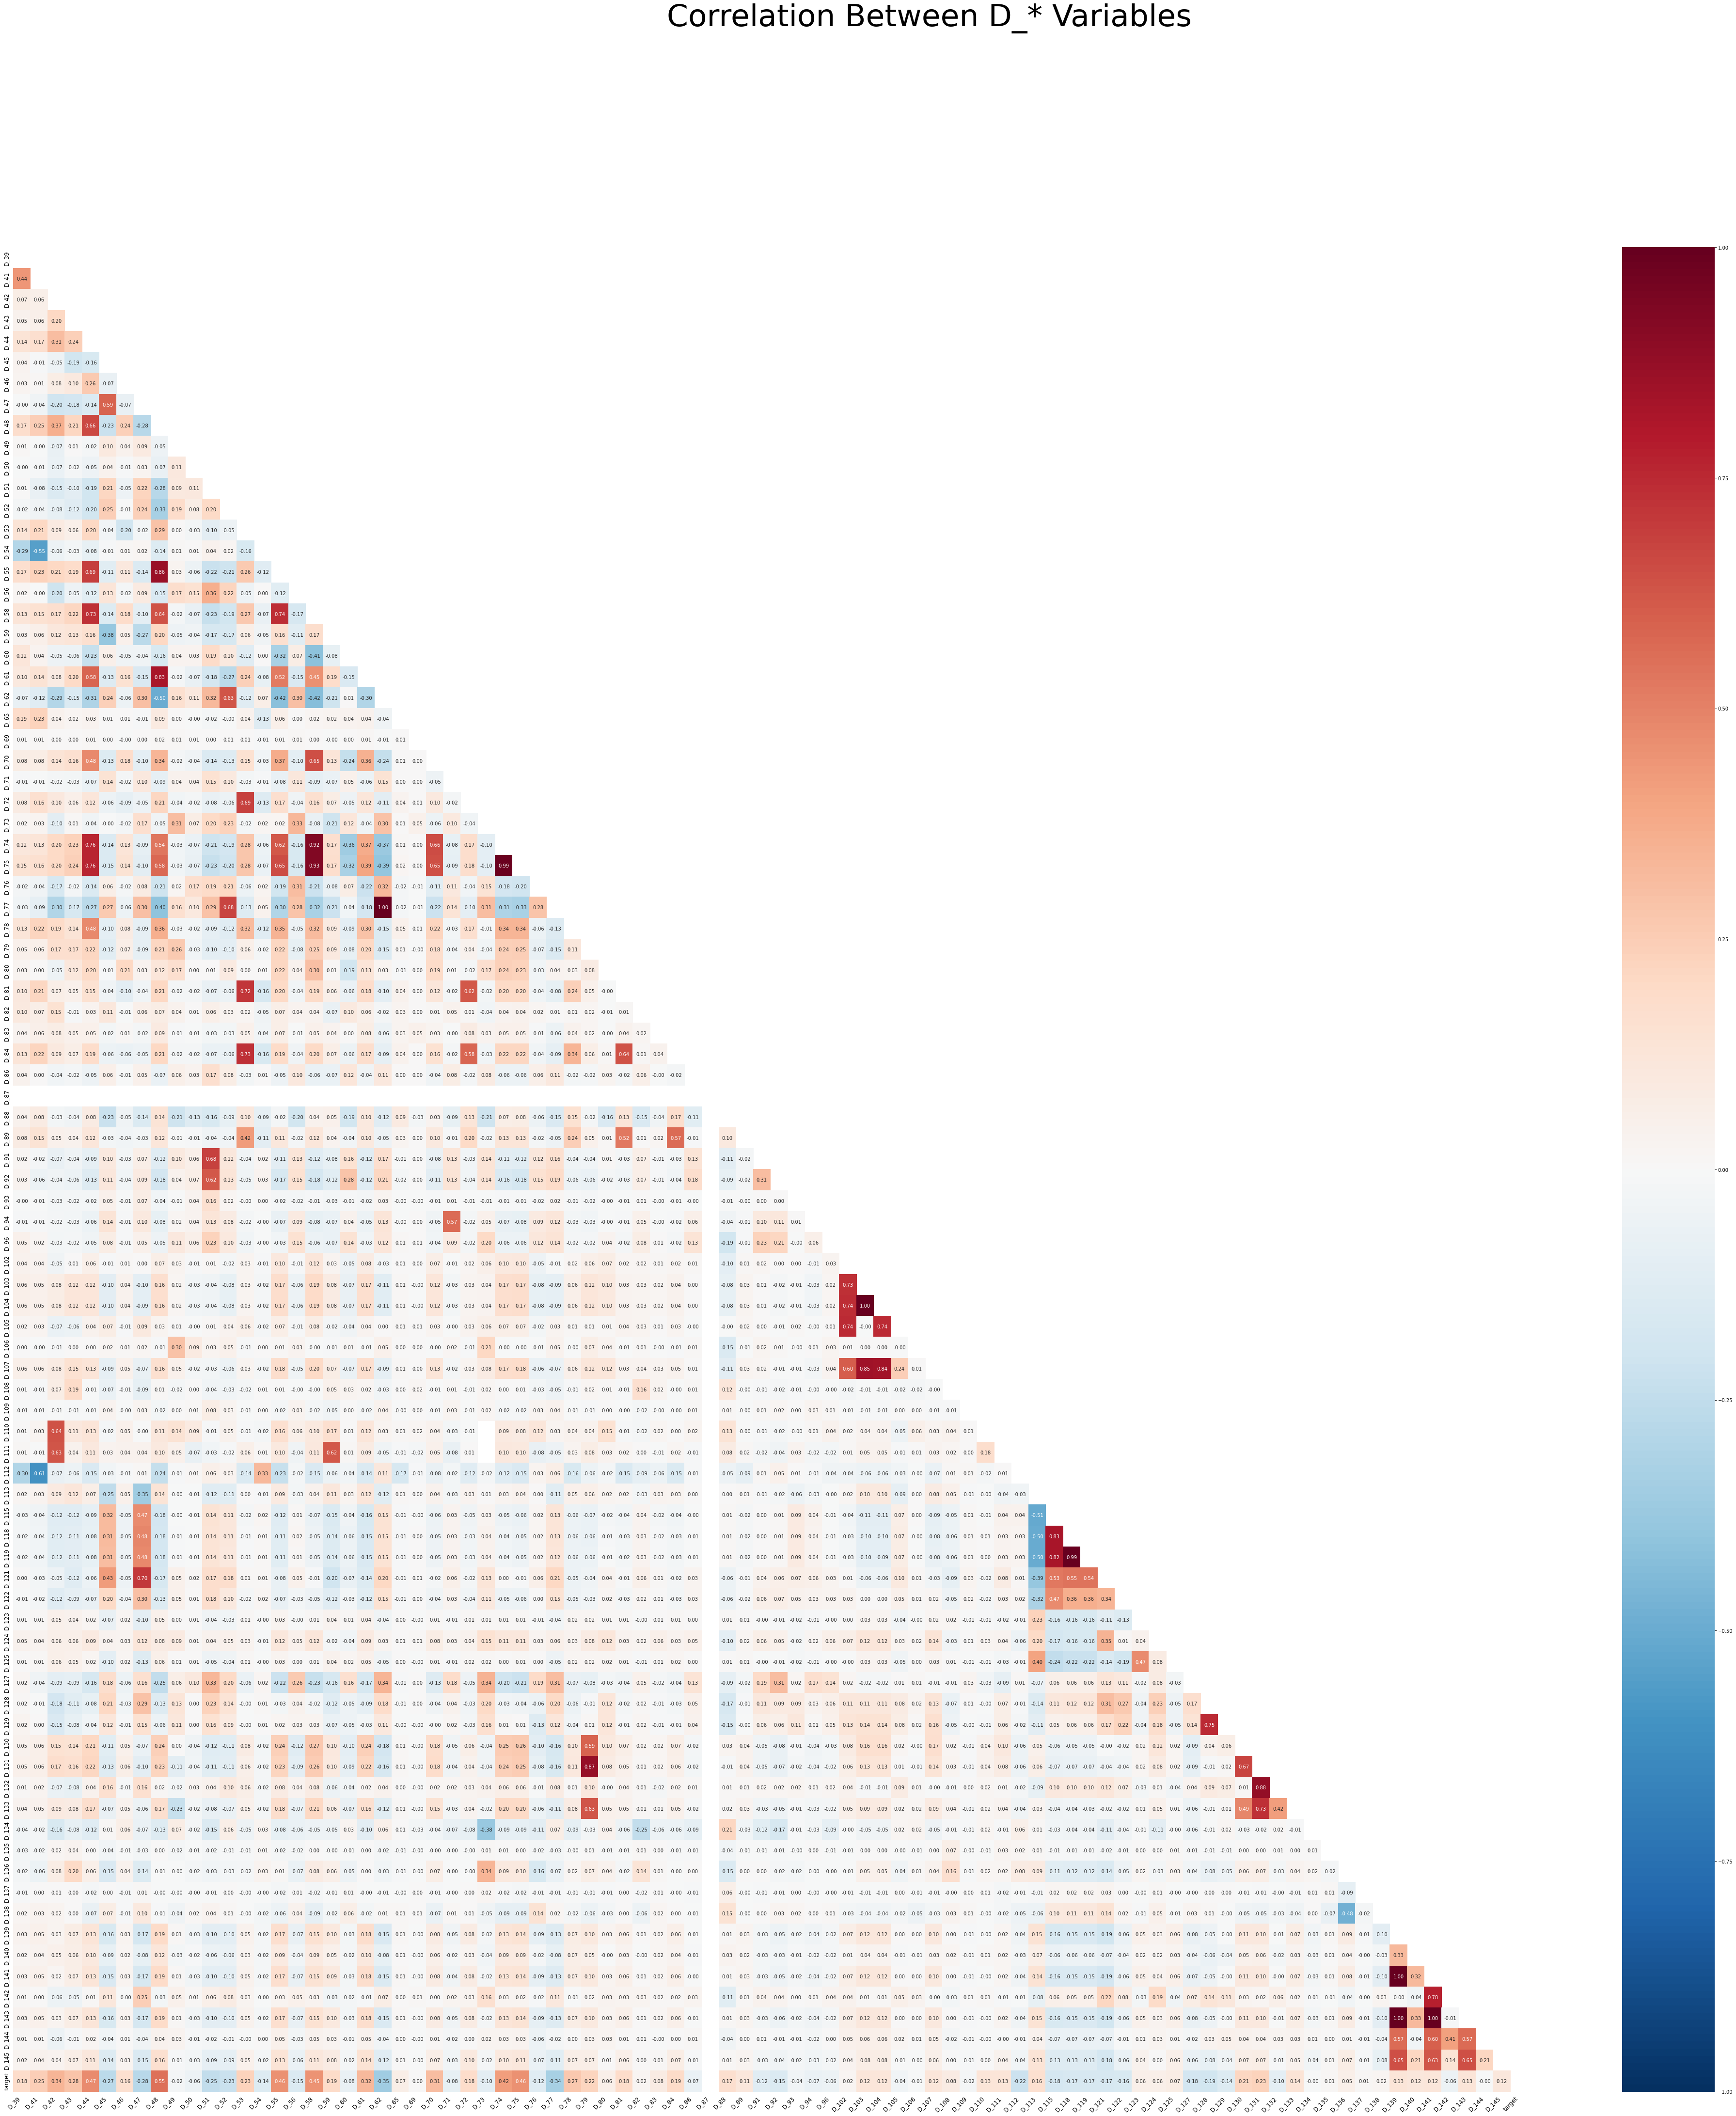

In [ ]:
heatmap_plotter(feature='D',figure=(70,70))

* Variable D:
    * D_47, D_48, D_54, D_55, D_57, D_61, D_62, D_70, D_72, D_74, D_75, D_77 these feature variable have correlation with other D type feature variable.
    * We need to handle the Correlation between the features.




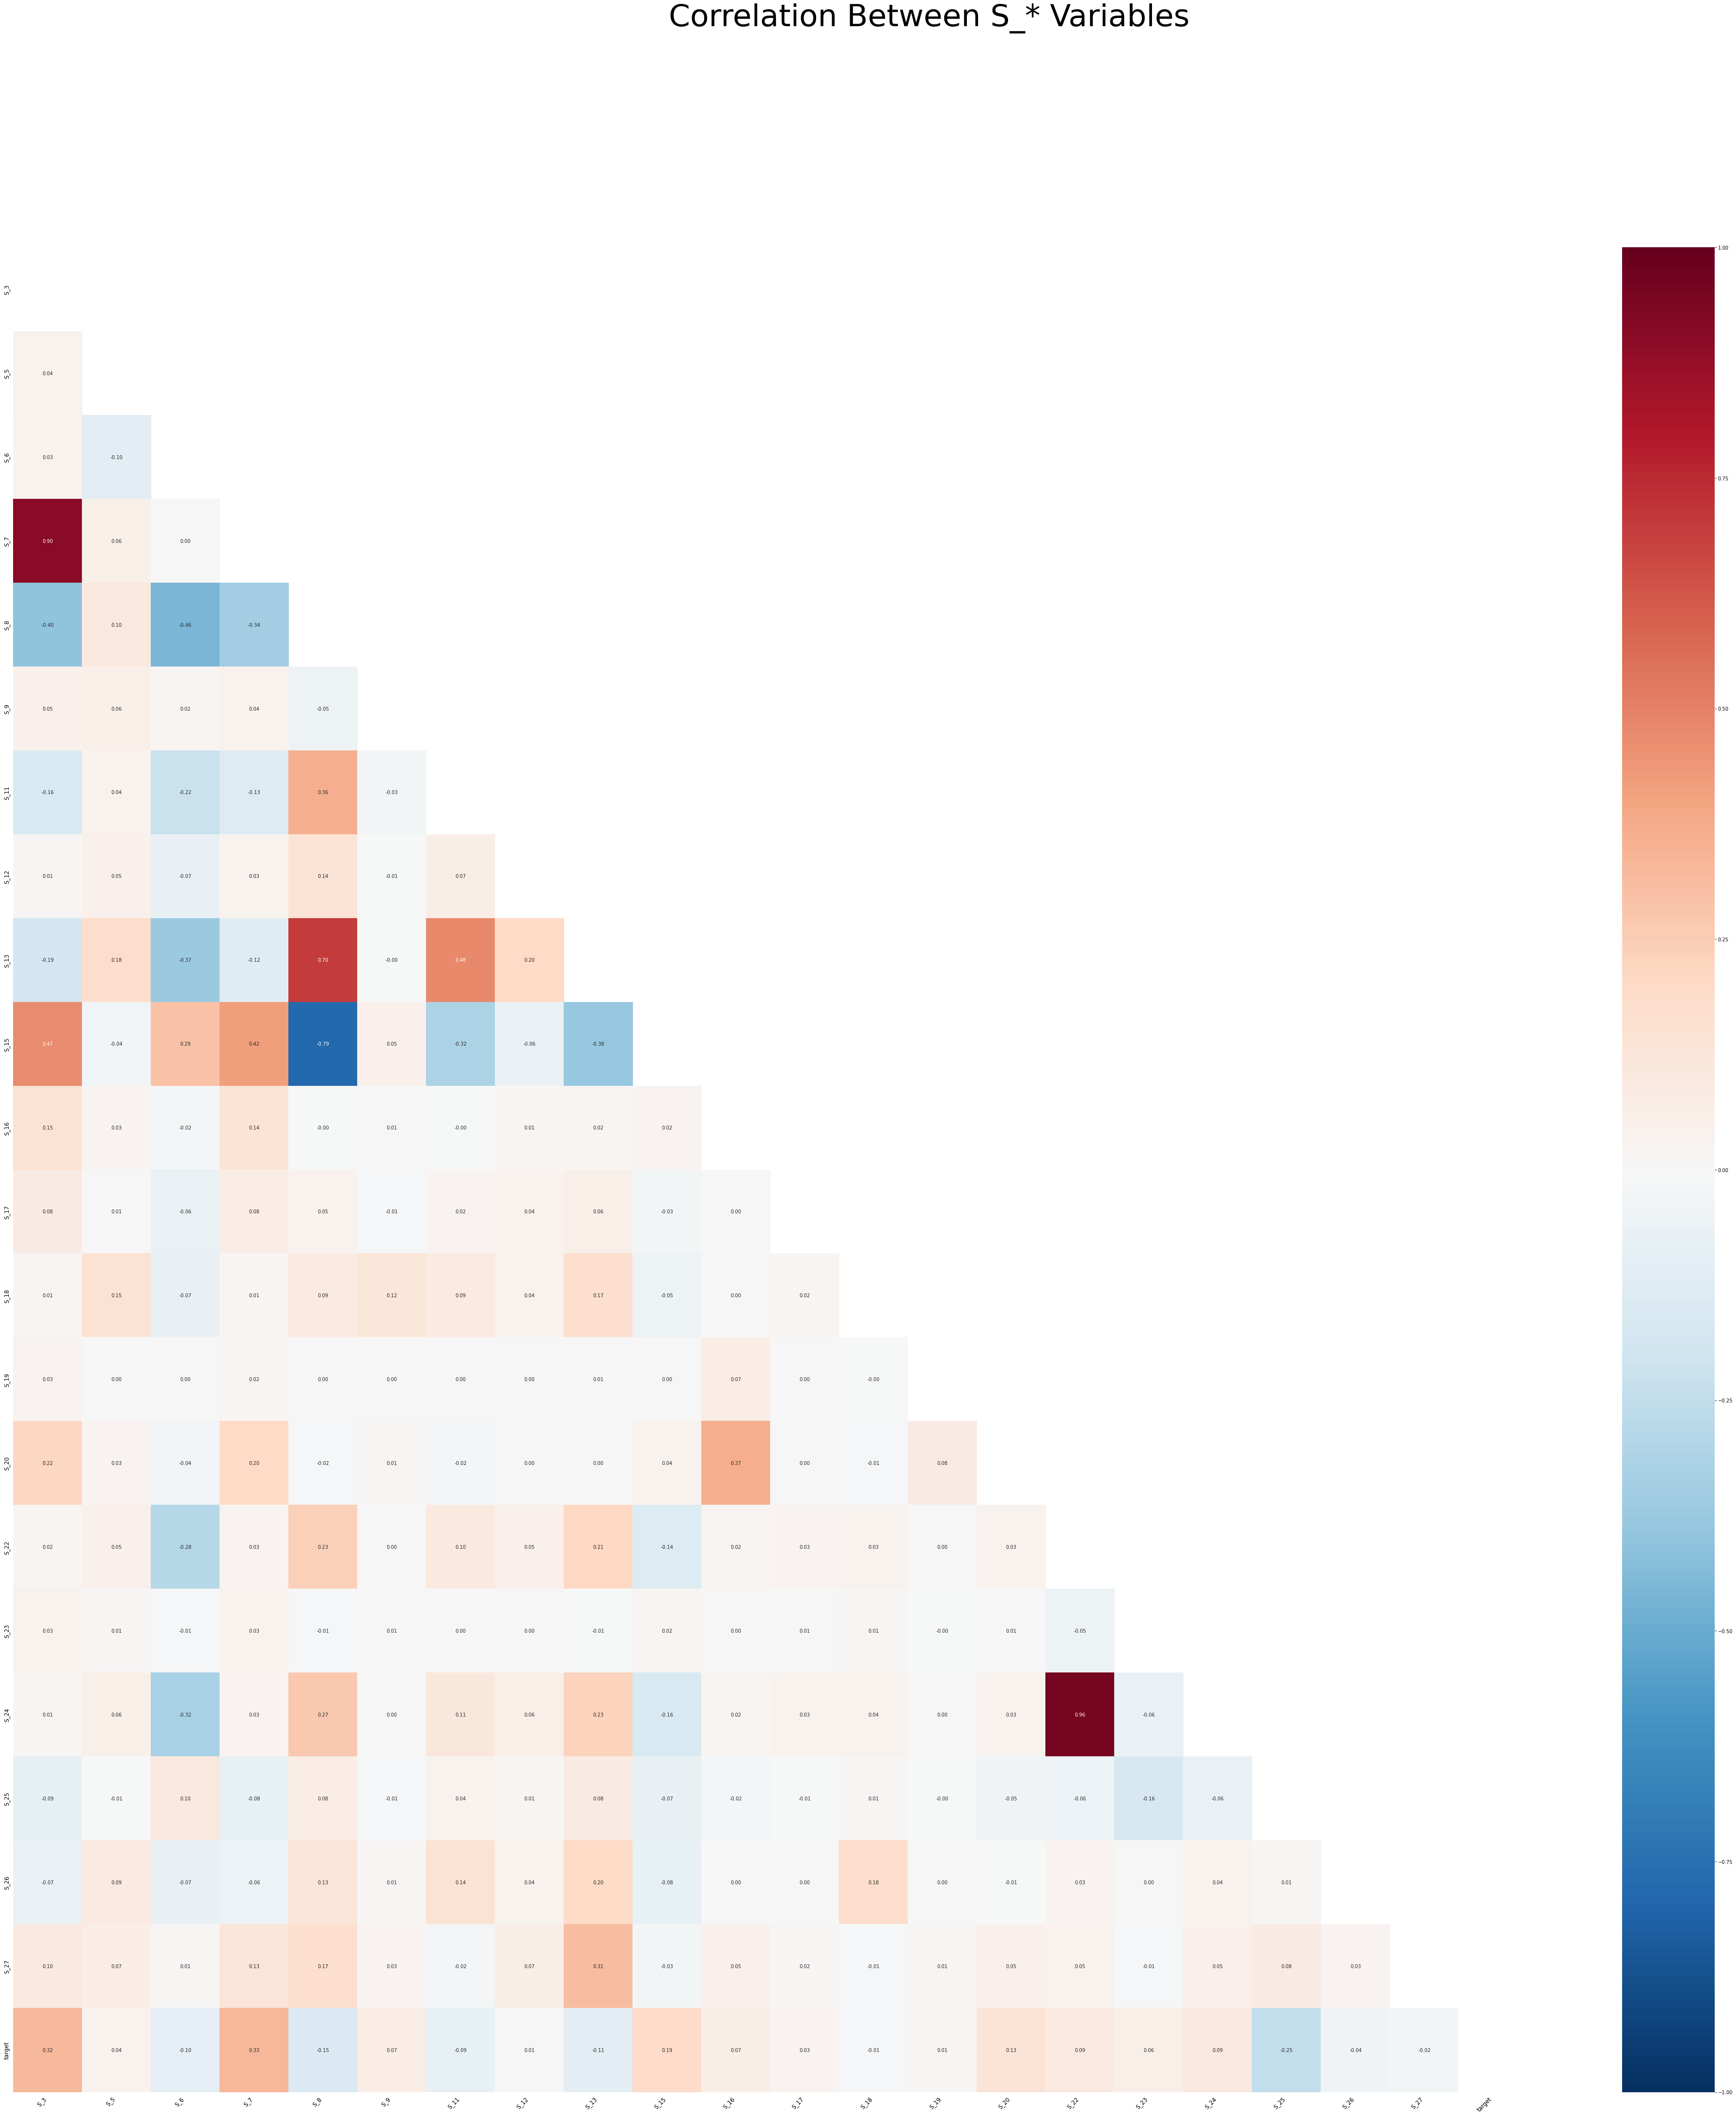

In [ ]:
heatmap_plotter(feature='S',figure=(70,70))

* Variable S:
    * S_8,S_13,S_15,S_24 these feature variable have correlation with other S type feature variable.
    * We need to handle the Correlation between the features.

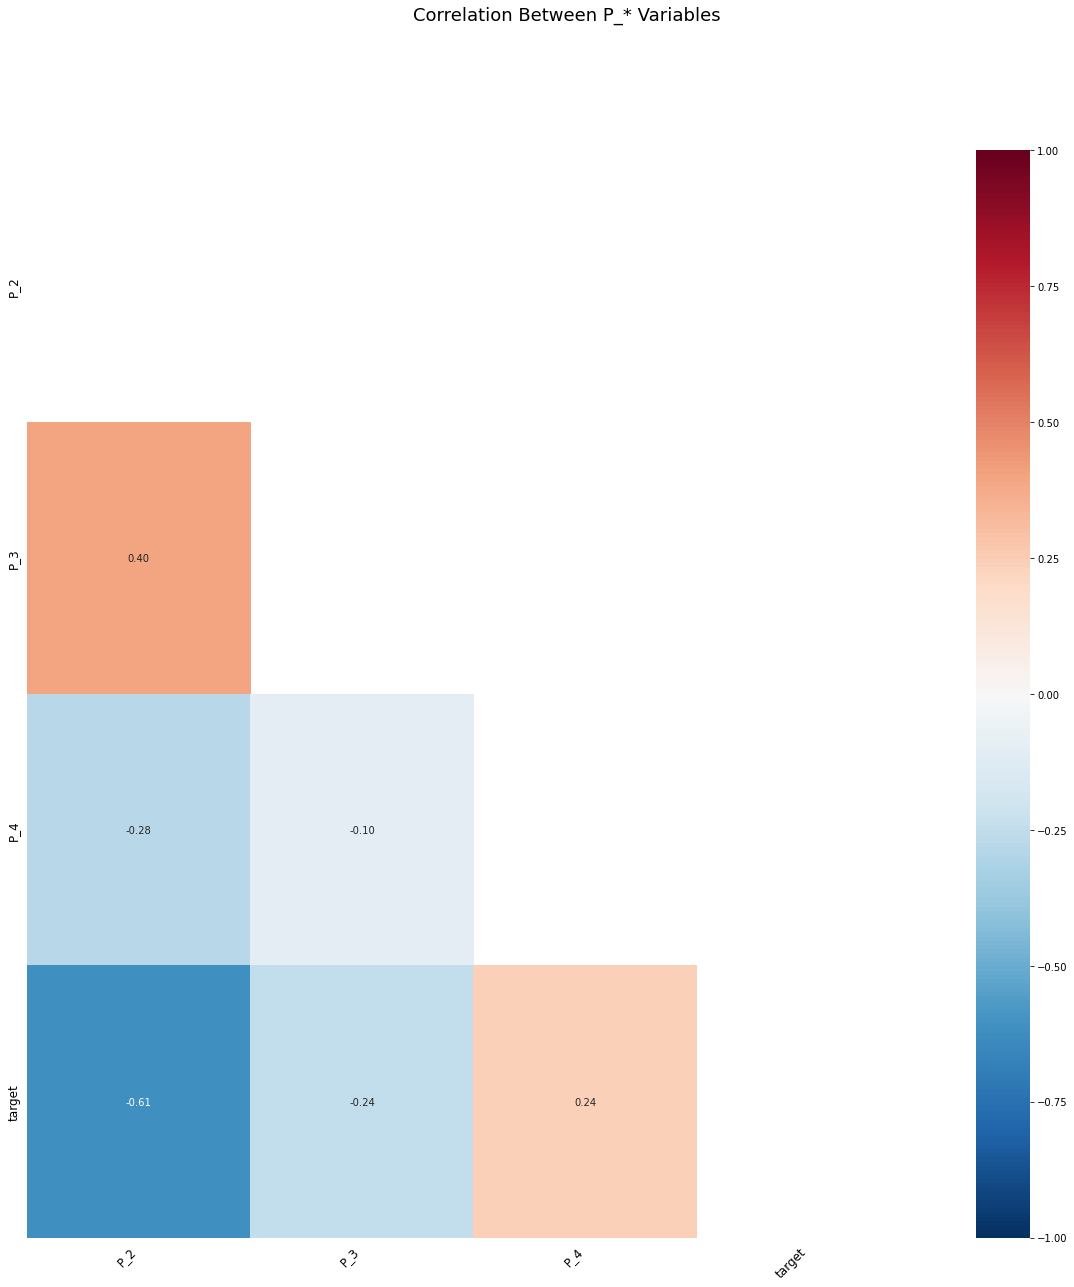

In [ ]:
heatmap_plotter(feature='P',figure=(20,20))

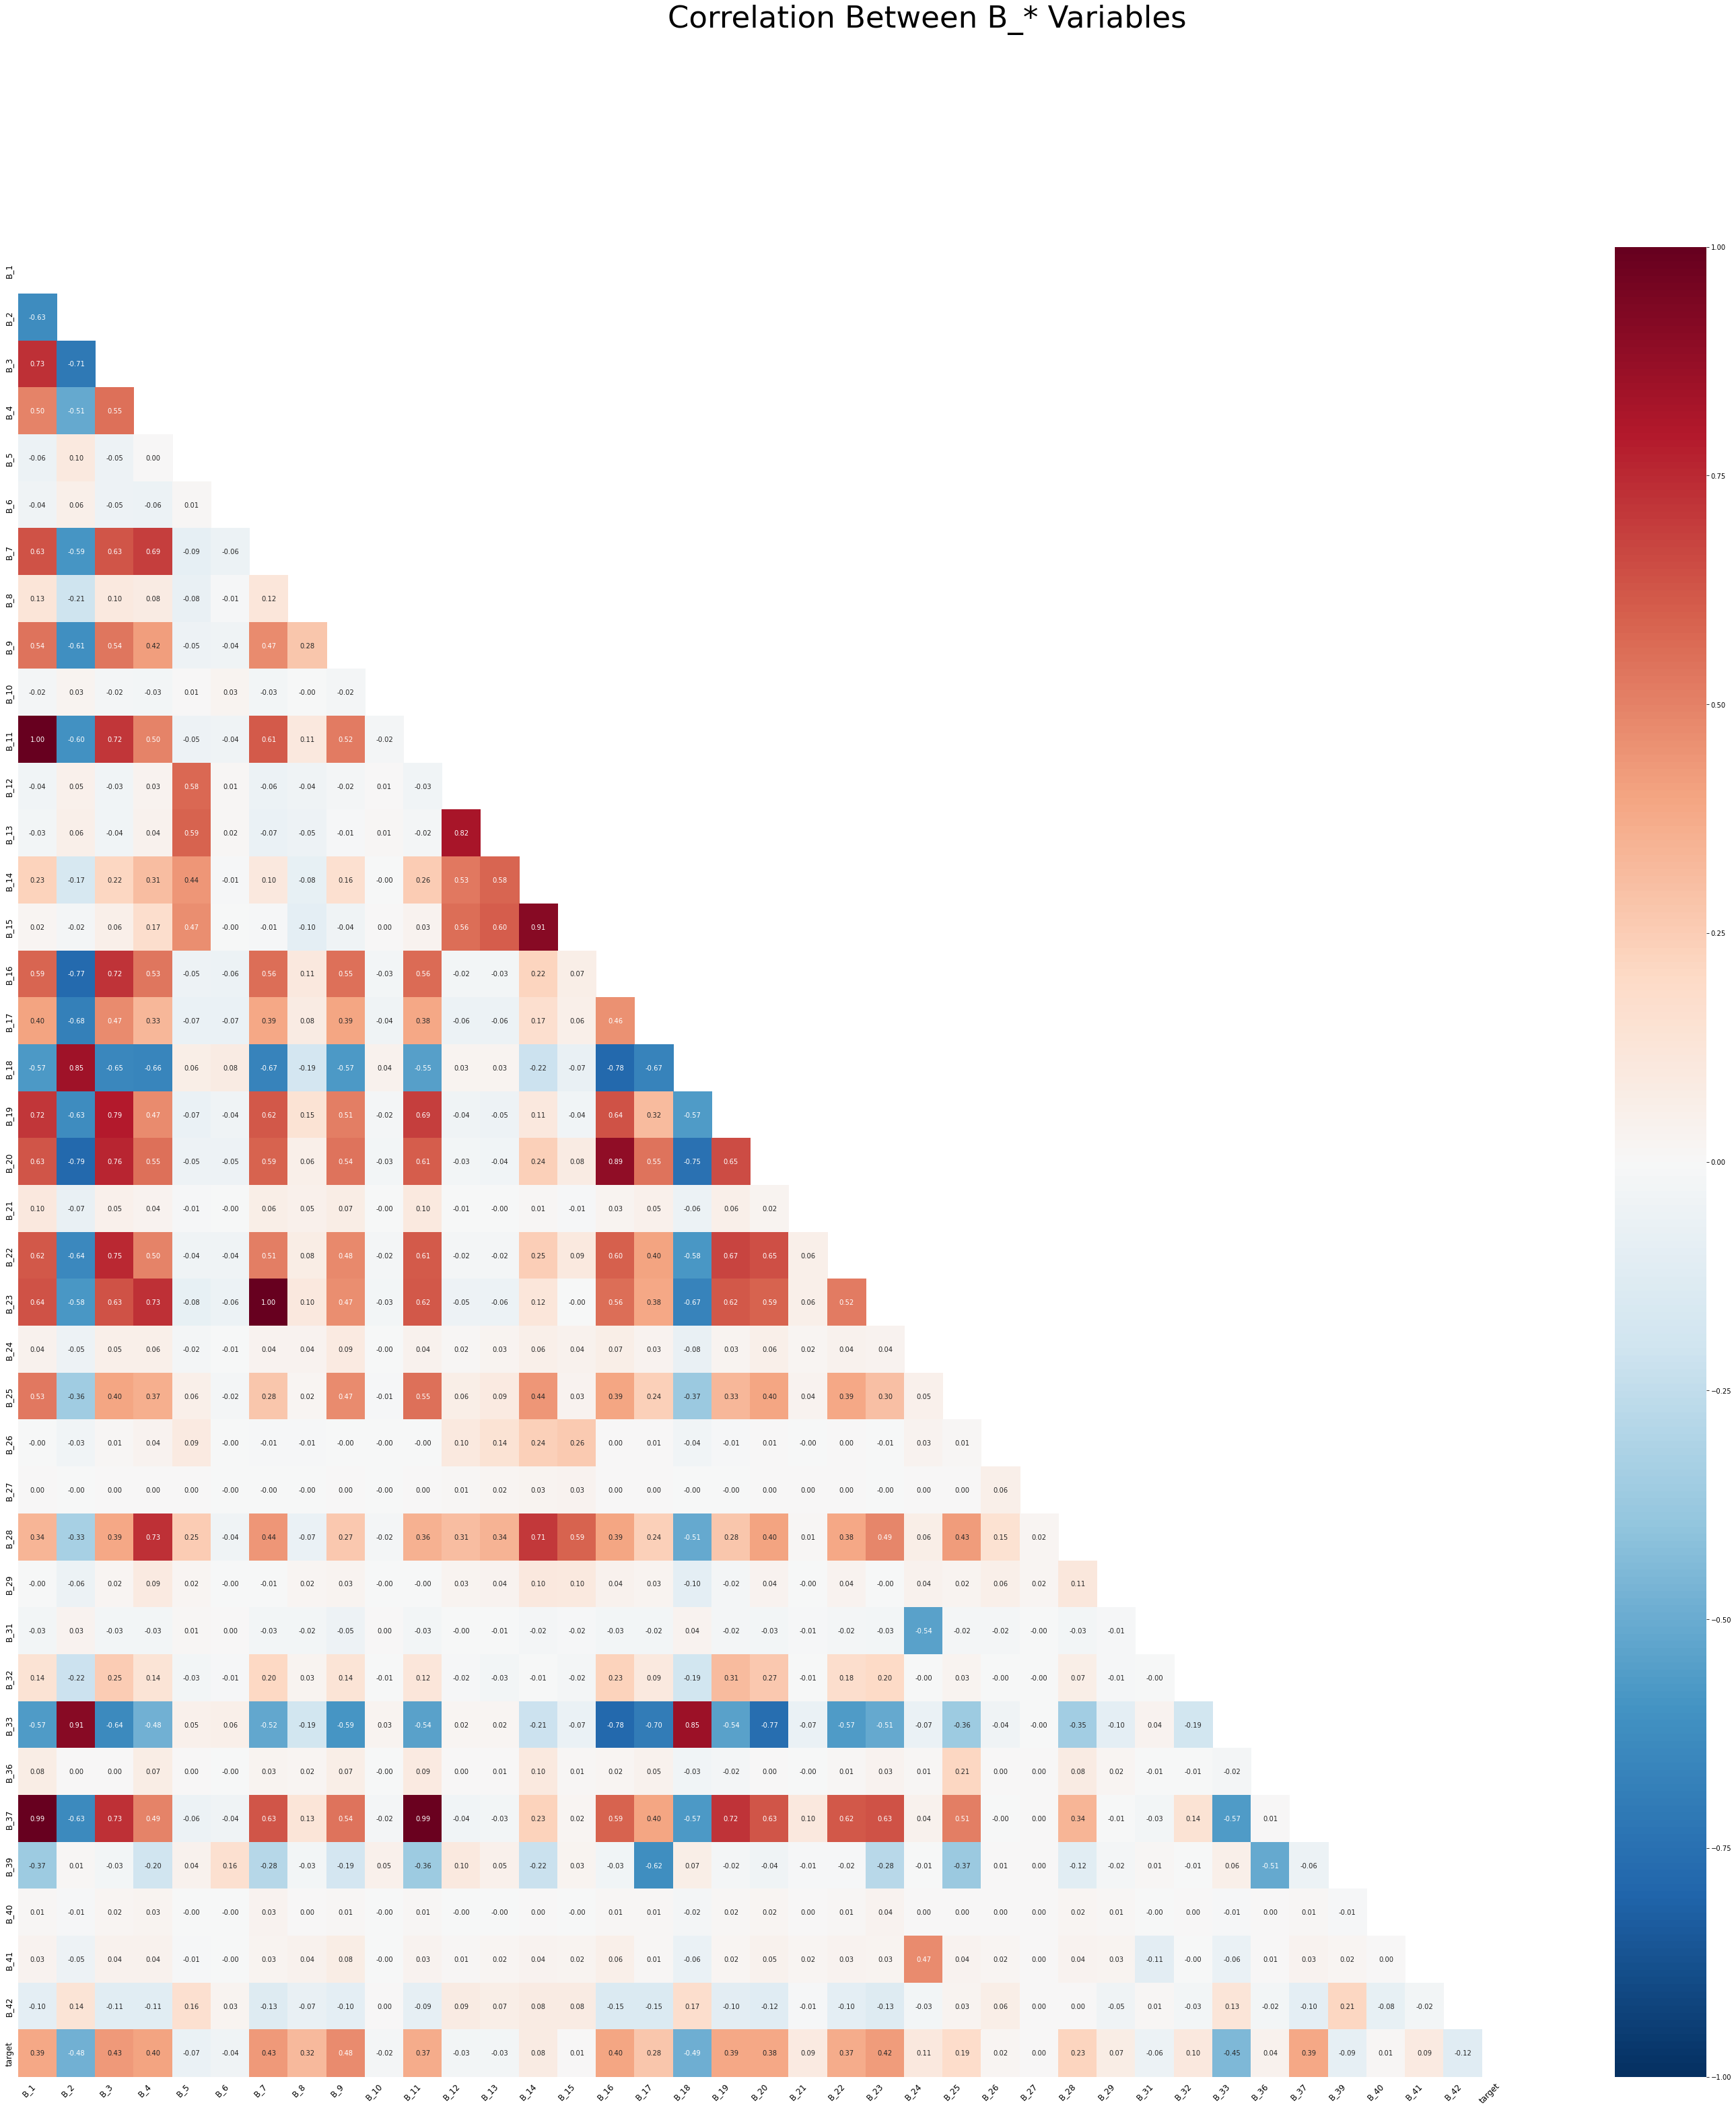

In [ ]:
heatmap_plotter(feature='B',figure=(50,50))

* Variable B:
    * around 18-20 B type feature variable have correlation with other B type feature variable.
    * We need to handle the Correlation between the features.

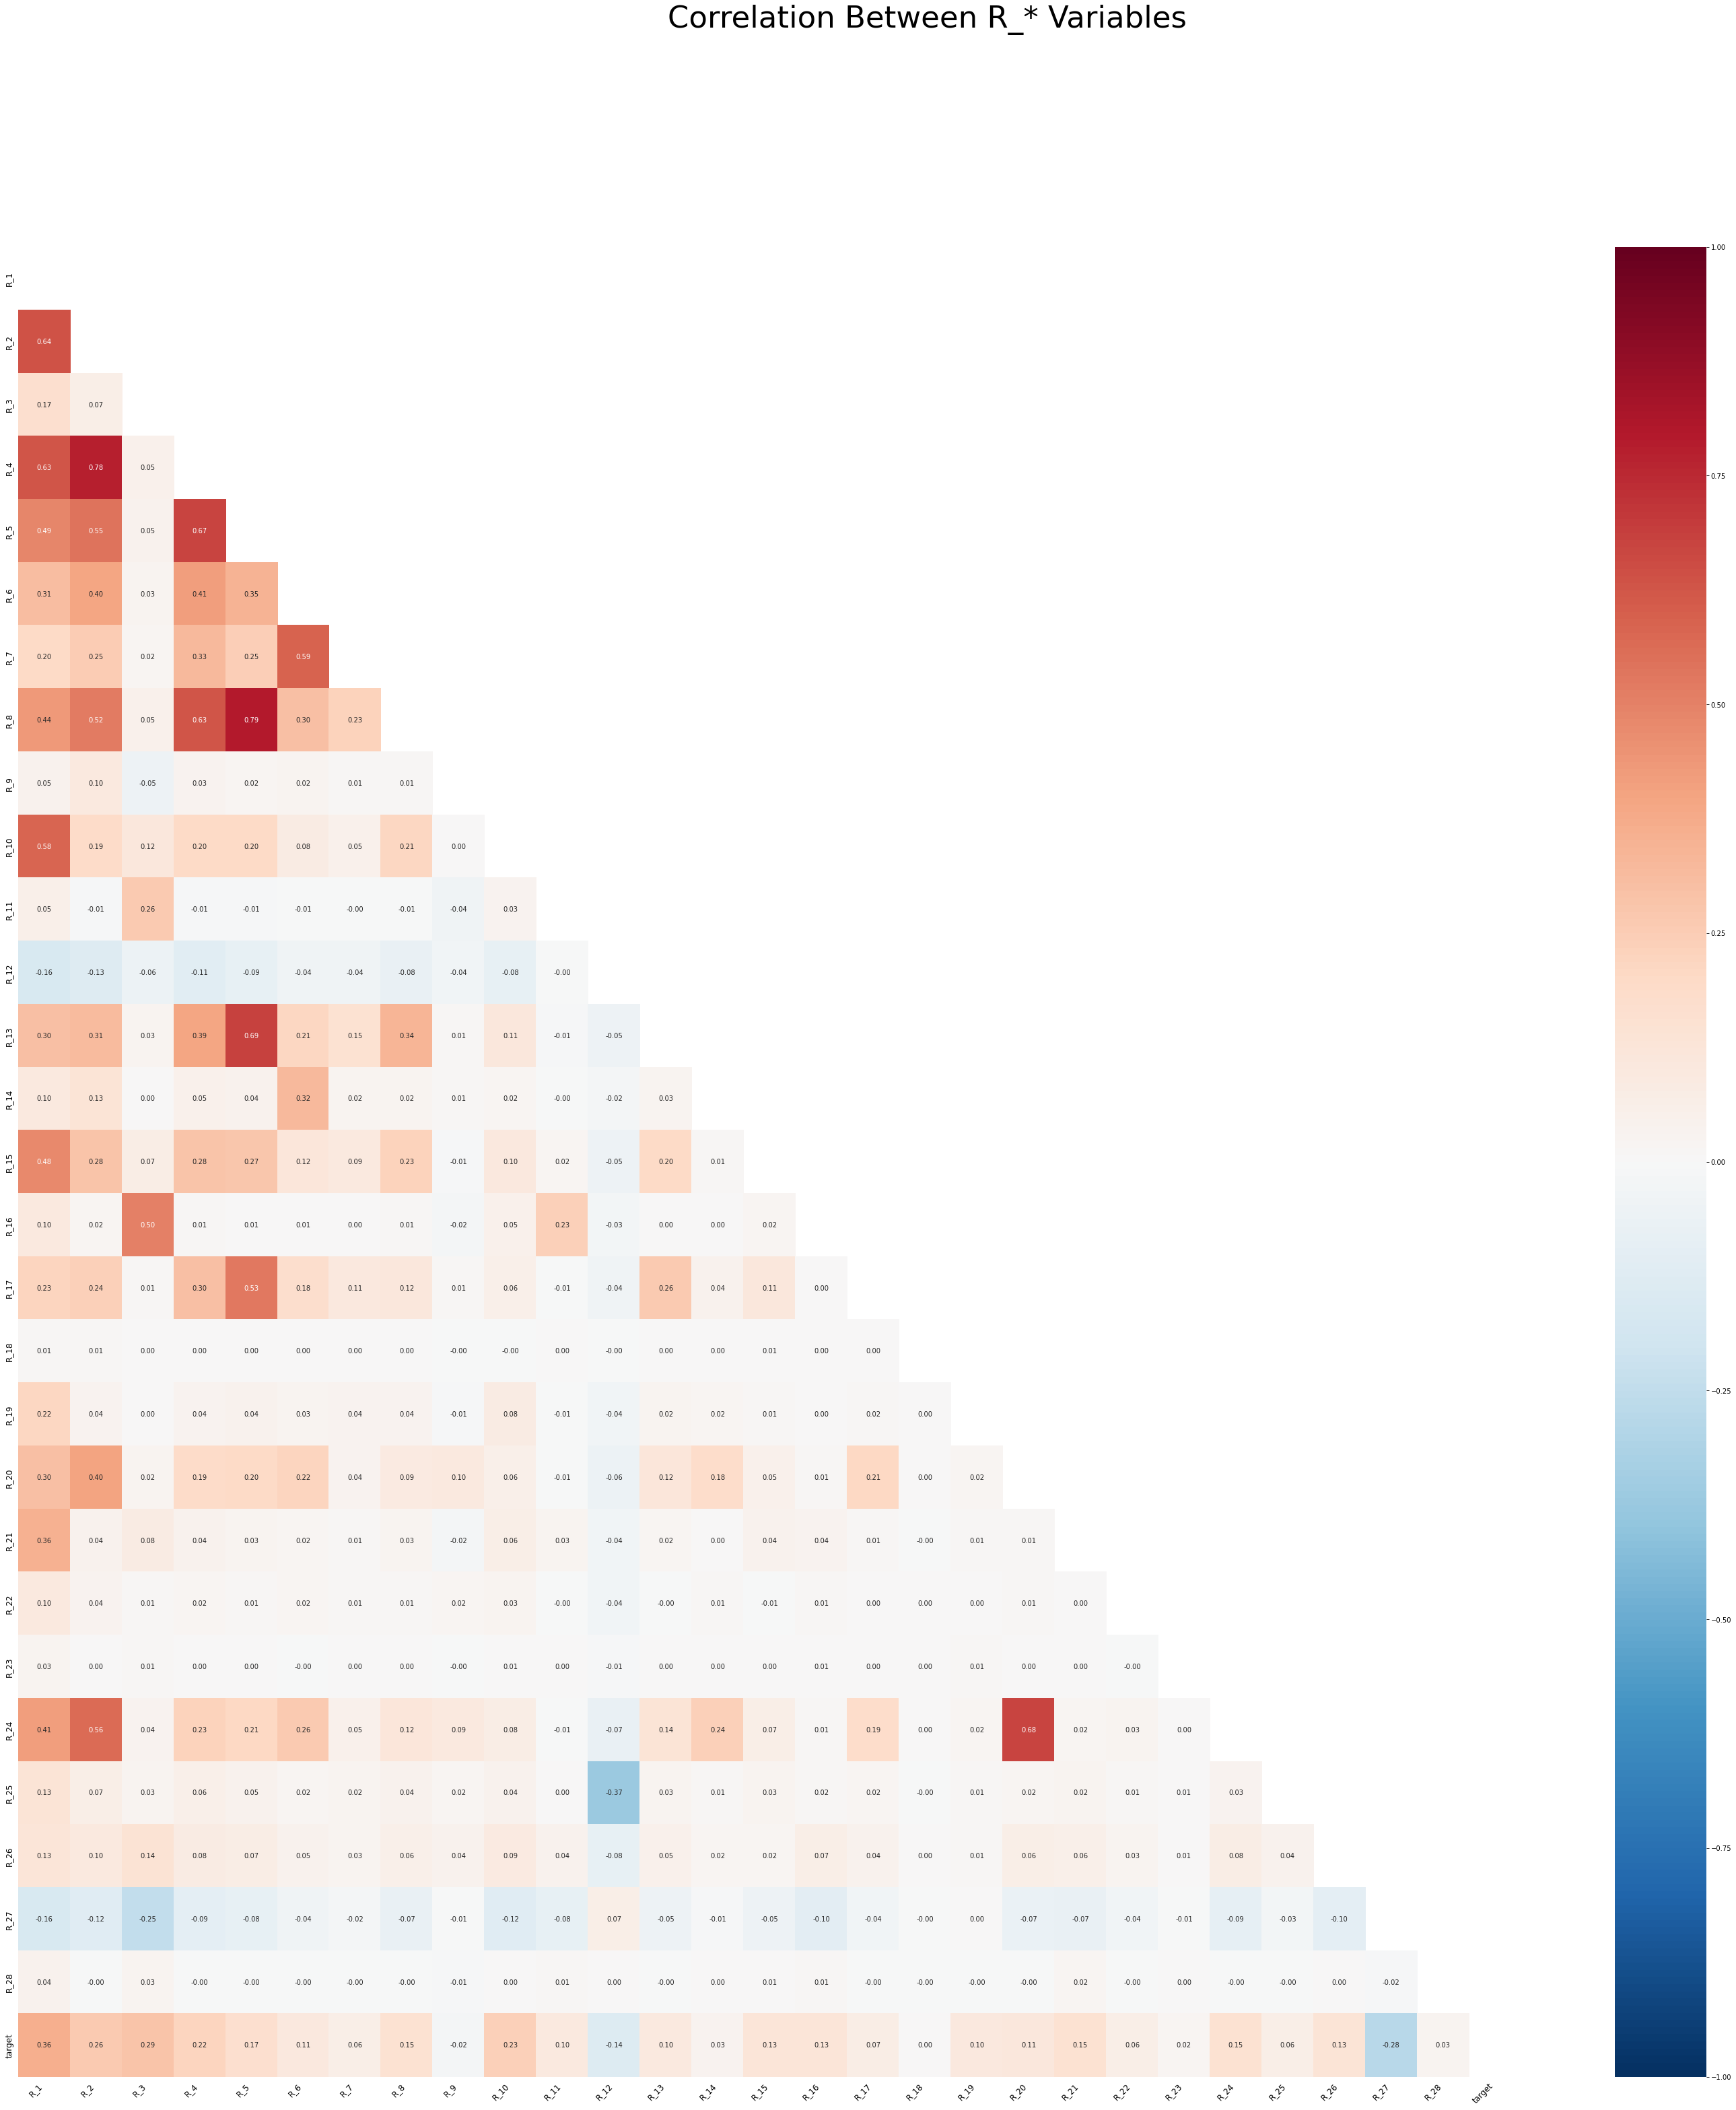

In [ ]:
heatmap_plotter(feature='R',figure=(50,50))

In [ ]:
heatmap_plotter(feature='all',figure=(180,180))

# Correlation with target

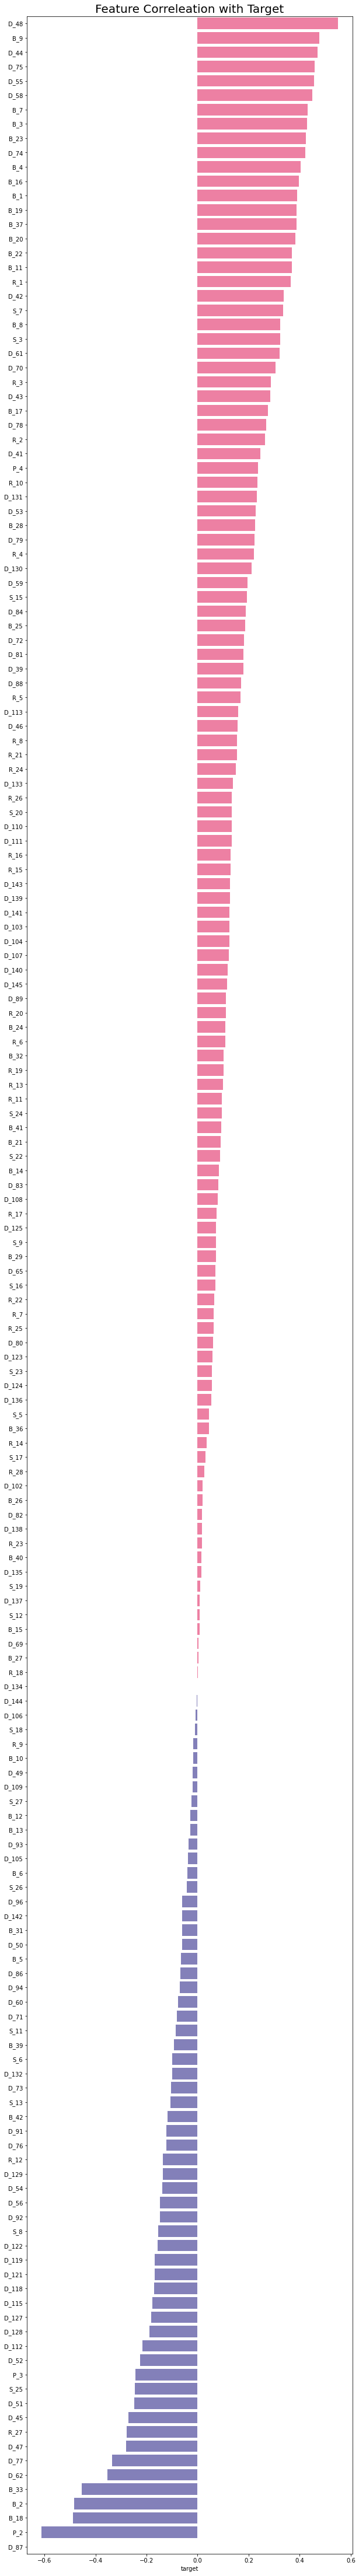

In [ ]:
#Correlation between variables and target
temp=train.corr()
temp=temp['target'].sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(10,80))
sns.barplot(x=temp[1:], y=temp.index[1:], orient='h', palette= ['#ff6e9c70'if y>0 else '#7A76C270' for y in temp[1:]])
plt.title('Feature Correleation with Target', fontsize=20)
plt.show()

del temp
_ = gc.collect()

* Correlation of diffrent features with the Target features:
    * D_48, B_9, D_44, D_75, D_58, D_55, D_7, B_3, D_23, D_74 has positive correlation with the target with correlation value >= 0.4.
    * P_2, B_18, B_2, B_33 has negative correlation with the target with correlation value <= -0.4.


#Conclusion:
* distribution of data:
    * The train Dataset has imbalanced class distribution.
    * there are around 10% customer which has the less than 13 statemnt.
* missing values:
    * The data set contains many colums with missing value.
    * Feature D & B type has highest missing values.
    * we will have to use imputation methods i.e.
        * Mean & Median replacement for the Numerical columns.
        * Mode or Most frequent value for the categorical columns.

* Outlier:
    * almost all  the features has the outlier problem, which will afftet the model perforamnce.
    * method we can opt for handling the outliers is:
        * Deleting the observations
        * Transforming values
        * Imputation
        * Separetely training
    * all the numerical columns has data in 0  to 1 range, hence we can say that the data is already normalized.

* Collinearity:
    * There are many features which are corrilated with each other hence data has the multicollinearity between variables hence we will need to keep in mind while training our model.





Note:
  Deployed web app case study link: https://american-express.herokuapp.com/

  Github repository link: https://github.com/BankaiXHunterr/Amrican_Express_default_predictor